In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import umap
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wilcoxon, spearmanr
from sklearn.cluster import KMeans


### Data preparation

In [2]:
df = pd.read_json("results/task2/task2_data.json", lines=True)
# --- Step 1: Expand lists to 2D arrays ---
ref_array = np.vstack(df["ref_embeddings"].to_numpy())
gen_array = np.vstack(df["gen_embeddings"].to_numpy())

zone_path = "datasets/job_zone.xlsx"
zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["area"] = df["code"].apply(lambda x: x.split("-")[0])
df["area"] = df["area"].astype("category")
df["code"] = df["code"].astype("category")
df["zone"] = df["zone"].astype("category")
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)

In [3]:
rows = []
# --- Process Reference Embeddings ---

df_ref_unique = df.drop_duplicates(subset=['code', 'model', 'iteration'])

for index, row in df_ref_unique.iterrows():
    # Normalize the reference embedding. reshape(1, -1) is used because normalize expects 2D array.
    normalized_ref_emb = normalize(np.array(row['ref_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'ref',
        'iteration': row['iteration'],
        'embedding': normalized_ref_emb.tolist()
    })

# --- Process Generated Embeddings for 'benchmark' prompt ---
# Filter the original DataFrame to get only rows where prompt is 'benchmark'.
df_benchmark = df[df['prompt'] == 'benchmark']
for index, row in df_benchmark.iterrows():
    # Normalize the generated embedding for 'benchmark'.
    normalized_gen_emb = normalize(np.array(row['gen_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'benchmark',
        'iteration': row['iteration'],
        'embedding': normalized_gen_emb.tolist()
    })

# --- Process Generated Embeddings for 'persona' prompt ---
# Filter the original DataFrame to get only rows where prompt is 'persona'.
df_persona = df[df['prompt'] == 'persona']
for index, row in df_persona.iterrows():
    # Normalize the generated embedding for 'persona'.
    normalized_gen_emb = normalize(np.array(row['gen_embeddings']).reshape(1, -1))[0]
    rows.append({
        'code': row['code'],
        'model': row['model'],
        'prompt': 'persona',
        'iteration': row['iteration'],
        'embedding': normalized_gen_emb.tolist()
    })

# Create the final DataFrame from the collected rows
df_all_embeddings = pd.DataFrame(rows)
df_all_embeddings['area'] = df_all_embeddings['code'].apply(lambda x: x.split("-")[0])
df_all_embeddings

,code,model,prompt,iteration,embedding,area
0,13-2011.00,deepseek-r1,ref,0,"[0.05778160785332616, 0.01709720408727697, 0.0...",13
1,27-2011.00,deepseek-r1,ref,0,"[0.05005398370231716, -0.02981496028224901, 0....",27
2,15-2011.00,deepseek-r1,ref,0,"[0.05492892375272339, 0.015017905886327511, -0...",15
3,29-1291.00,deepseek-r1,ref,0,"[0.053923153767784684, -0.0455680314558533, 0....",29
4,29-1141.01,deepseek-r1,ref,0,"[0.05438733459911409, -0.06101214072395544, -0...",29
...,...,...,...,...,...,...
105475,15-1212.00,mistral,persona,2,"[0.03437775664310248, 0.04420883218474737, -2....",15
105476,15-1299.09,mistral,persona,2,"[0.051093116181008175, 0.004663755680010529, -...",15
105477,51-9061.00,mistral,persona,2,"[0.013496475784975733, -0.02807629763663796, -...",51
105478,25-9031.00,mistral,persona,2,"[0.08827292825751913, -0.03991977087378076, -0...",25


In [4]:
# Step 1: Group by model and job code
groups = df_all_embeddings.groupby(['model', 'code', 'iteration'])

# Step 2: Compute cosine similarity between each benchmark/persona and the reference
similarity_rows = []

for (model, code, iteration), group in groups:
    # Extract rows by prompt type
    ref_row = group[group['prompt'] == 'ref']
    bench_row = group[group['prompt'] == 'benchmark']
    pers_row = group[group['prompt'] == 'persona']
    
    if len(ref_row) != 1:
        continue  # Skip if ref embedding is missing
    ref_emb = np.array(ref_row['embedding'].values[0]).reshape(1, -1)
    
    for prompt, row in [('benchmark', bench_row), ('persona', pers_row)]:
        if len(row) != 1:
            continue  # Skip if prompt type is missing
        gen_emb = np.array(row['embedding'].values[0]).reshape(1, -1)
        sim = cosine_similarity(ref_emb, gen_emb).item()
        
        similarity_rows.append({
            'model': model,
            'prompt': prompt,
            'similarity': sim,
            'code': code,
            'area': row['area'].values[0],
            'iteration': iteration
        })

# Step 3: Create a new DataFrame for plotting
row_level_similarity = pd.DataFrame(similarity_rows)
row_level_similarity

,model,prompt,similarity,code,area,iteration
0,deepseek-r1,benchmark,0.867923,11-1011.00,11,0
1,deepseek-r1,persona,0.846140,11-1011.00,11,0
2,deepseek-r1,benchmark,0.779322,11-1011.00,11,1
3,deepseek-r1,persona,0.453507,11-1011.00,11,1
4,deepseek-r1,benchmark,0.833973,11-1011.00,11,2
...,...,...,...,...,...,...
70315,mistral,persona,0.899087,53-7121.00,53,7
70316,mistral,benchmark,0.877932,53-7121.00,53,8
70317,mistral,persona,0.885201,53-7121.00,53,8
70318,mistral,benchmark,0.896262,53-7121.00,53,9


In [5]:
row_sim_filtered = row_level_similarity[row_level_similarity['similarity'] > 0.4]
zone_path = "datasets/job_zone.xlsx"
zone = pd.read_excel(zone_path)
zone = zone[['O*NET-SOC Code', 'Job Zone']]
zone.columns = ['code', 'zone']
row_sim_filtered = row_sim_filtered.merge(zone, on='code', how='left')
row_sim_filtered


,model,prompt,similarity,code,area,iteration,zone
0,deepseek-r1,benchmark,0.867923,11-1011.00,11,0,5
1,deepseek-r1,persona,0.846140,11-1011.00,11,0,5
2,deepseek-r1,benchmark,0.779322,11-1011.00,11,1,5
3,deepseek-r1,persona,0.453507,11-1011.00,11,1,5
4,deepseek-r1,benchmark,0.833973,11-1011.00,11,2,5
...,...,...,...,...,...,...,...
70145,mistral,persona,0.899087,53-7121.00,53,7,2
70146,mistral,benchmark,0.877932,53-7121.00,53,8,2
70147,mistral,persona,0.885201,53-7121.00,53,8,2
70148,mistral,benchmark,0.896262,53-7121.00,53,9,2


In [6]:
key_cols = ['model', 'code', 'prompt', 'iteration']

# Keep all 'ref' rows, plus those matching filtered_keys for other prompts
df_all_embeddings = pd.concat([
    df_all_embeddings[df_all_embeddings['prompt'] == 'ref'],
    pd.merge(
        df_all_embeddings[df_all_embeddings['prompt'] != 'ref'],
        row_sim_filtered[key_cols],
        on=key_cols,
        how='inner'
    )
], ignore_index=True)

df_all_embeddings

,code,model,prompt,iteration,embedding,area
0,13-2011.00,deepseek-r1,ref,0,"[0.05778160785332616, 0.01709720408727697, 0.0...",13
1,27-2011.00,deepseek-r1,ref,0,"[0.05005398370231716, -0.02981496028224901, 0....",27
2,15-2011.00,deepseek-r1,ref,0,"[0.05492892375272339, 0.015017905886327511, -0...",15
3,29-1291.00,deepseek-r1,ref,0,"[0.053923153767784684, -0.0455680314558533, 0....",29
4,29-1141.01,deepseek-r1,ref,0,"[0.05438733459911409, -0.06101214072395544, -0...",29
...,...,...,...,...,...,...
105305,15-1212.00,mistral,persona,2,"[0.03437775664310248, 0.04420883218474737, -2....",15
105306,15-1299.09,mistral,persona,2,"[0.051093116181008175, 0.004663755680010529, -...",15
105307,51-9061.00,mistral,persona,2,"[0.013496475784975733, -0.02807629763663796, -...",51
105308,25-9031.00,mistral,persona,2,"[0.08827292825751913, -0.03991977087378076, -0...",25


In [7]:
# Average embeddings correctly for each group
def average_embedding(embeddings):
	arrs = np.stack(embeddings)
	return arrs.mean(axis=0)

df_all_embeddings_avg = df_all_embeddings.groupby(['code', 'model', 'prompt','area'])['embedding'].apply(average_embedding).reset_index()
zone = pd.read_excel(zone_path)
zone = zone[['O*NET-SOC Code', 'Job Zone']]
zone.columns = ['code', 'zone']
df_all_embeddings_avg = df_all_embeddings_avg.merge(zone, on='code', how='left')
df_all_embeddings_avg

,code,model,prompt,area,embedding,zone
0,11-1011.00,deepseek-r1,benchmark,11,"[0.06001701198521865, 0.007385621778832914, -0...",5
1,11-1011.00,deepseek-r1,persona,11,"[0.048555013813699185, 0.001339454172301693, -...",5
2,11-1011.00,deepseek-r1,ref,11,"[0.0471675836018035, -0.019213052215599467, 0....",5
3,11-1011.00,llama3b,benchmark,11,"[0.058747649047549755, -0.008112463845566466, ...",5
4,11-1011.00,llama3b,persona,11,"[0.05739399019235834, 0.0018368545203588371, -...",5
...,...,...,...,...,...,...
10543,53-7121.00,llama70b,persona,53,"[0.004284111738706632, 0.03530827392471518, -0...",2
10544,53-7121.00,llama70b,ref,53,"[-0.023427307399909062, 0.015767238865333155, ...",2
10545,53-7121.00,mistral,benchmark,53,"[0.013810852373519217, 0.017196451317560302, 0...",2
10546,53-7121.00,mistral,persona,53,"[0.01564492935037696, 0.027022842345182492, 0....",2


### Descriptive stats

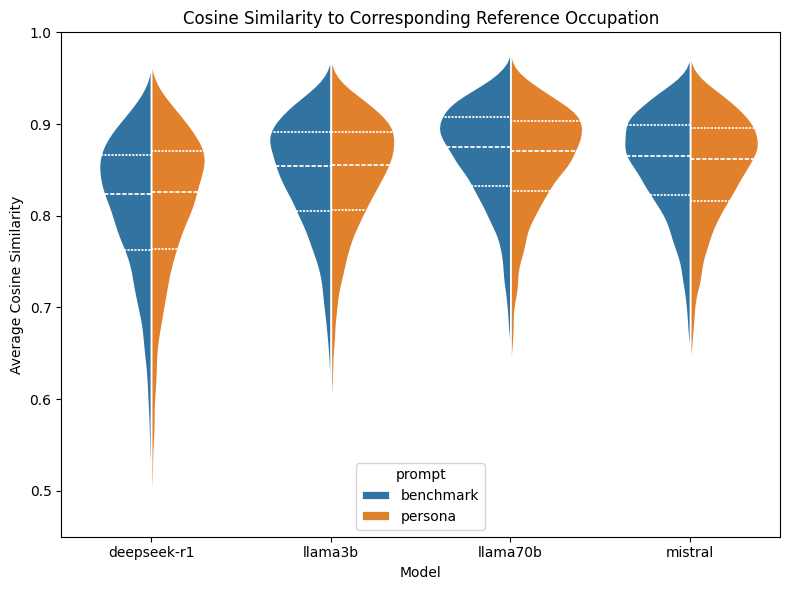

In [8]:
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=row_sim_filtered, 
    x="model", 
    y="similarity", 
    hue="prompt", 
    split=True, 
    inner="quartile",  # You can tune this
    alpha=1, 
    edgecolor="white"
)
plt.title("Cosine Similarity to Corresponding Reference Occupation")
plt.xlabel("Model")
plt.ylabel("Average Cosine Similarity")
plt.ylim(0.45, 1)
plt.tight_layout()
plt.show()

In [9]:
summary = (
    row_sim_filtered
    .groupby(['model', 'prompt'])['similarity']
    .agg(['mean', 'median', 'std'])
    .unstack('prompt')
    .sort_index(axis=1, level=0)
).reset_index().map(lambda x: x.capitalize() if isinstance(x, str) else x).rename(columns={'index': 'Model'})
summary

model      mean              median                 std  \
prompt              benchmark   persona benchmark   persona benchmark   
0       Deepseek-r1  0.805012  0.805659  0.823200  0.826140  0.085463   
1           Llama3b  0.840700  0.839992  0.853862  0.854953  0.070006   
2          Llama70b  0.862765  0.857318  0.875497  0.870397  0.062701   
3           Mistral  0.854366  0.849785  0.865174  0.861758  0.061538   

                  
prompt   persona  
0       0.091212  
1       0.072094  
2       0.064745  
3       0.063290

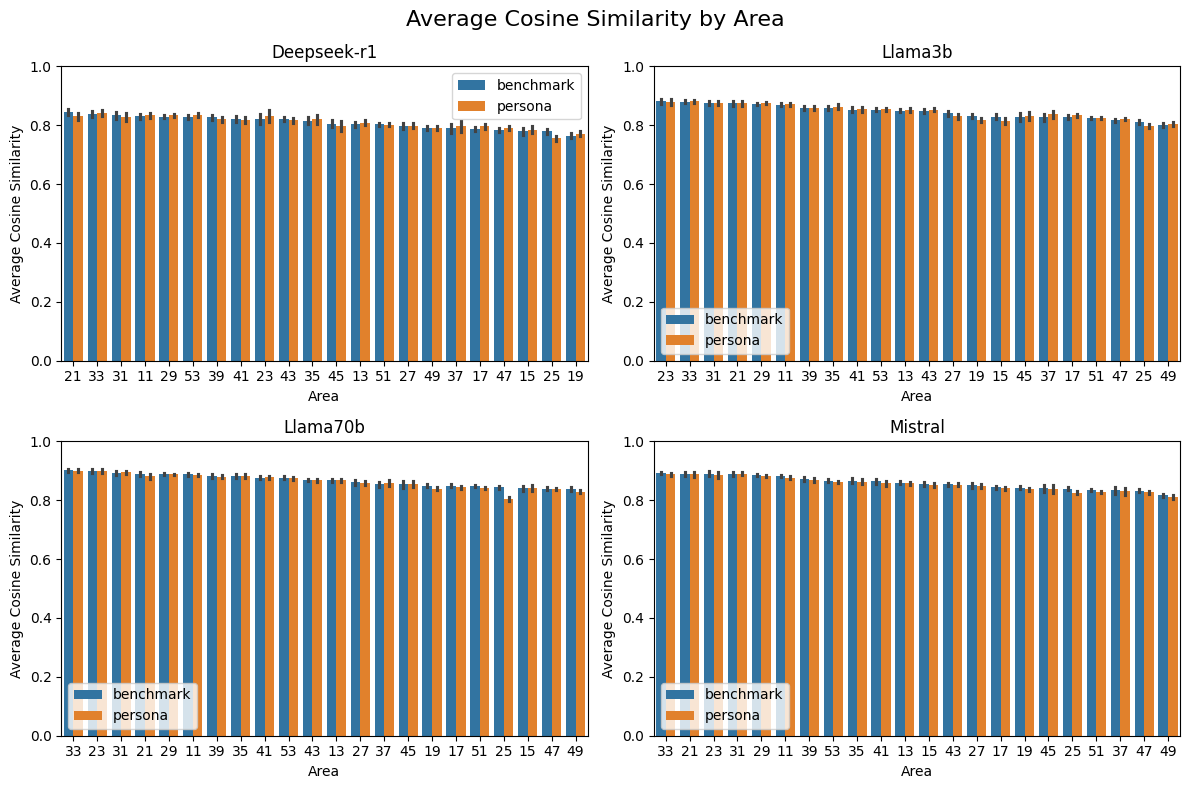

In [10]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 8))
plt.suptitle("Average Cosine Similarity by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = row_sim_filtered[row_sim_filtered['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['similarity']].mean()
    df_diff_sorted = df_diff.sort_values(by='similarity', ascending=False).index
    # sns.stripplot(data=df_model, x="area", y="similarity", hue="prompt", dodge=True, 
    #           size=5, alpha=0.5, jitter=True, order=df_diff_sorted)
    sns.barplot(data=df_model, x="area", y="similarity", hue="prompt", 
               order=df_diff_sorted, errorbar='ci', alpha=1)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Area')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])
plt.tight_layout()
plt.show()

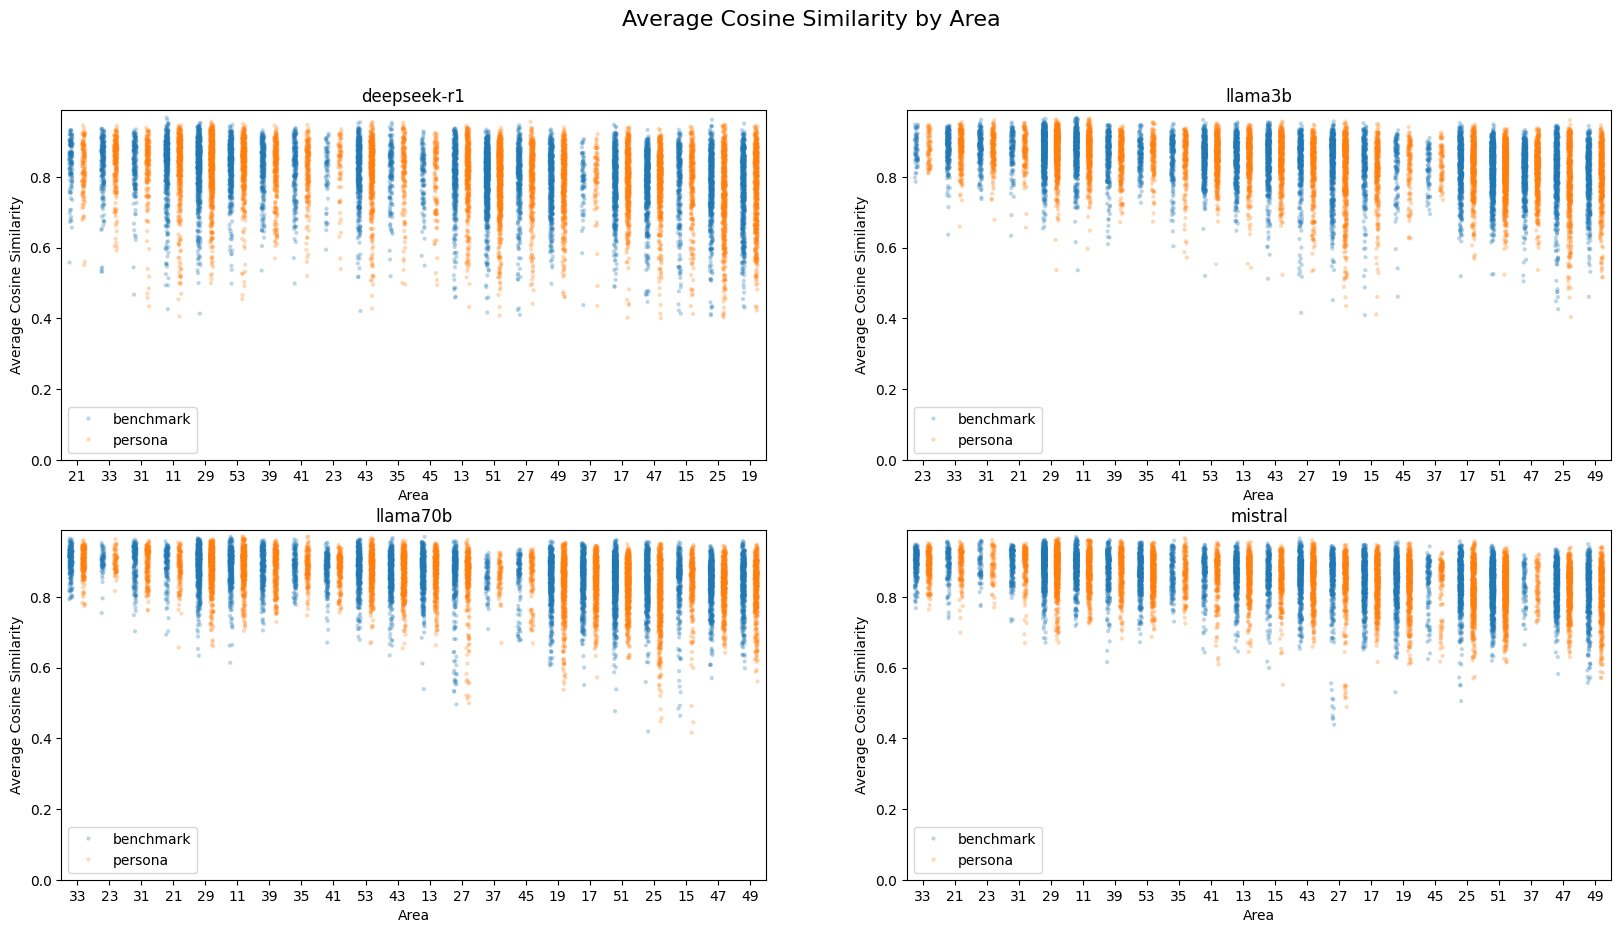

In [11]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(20, 10))
plt.suptitle("Average Cosine Similarity by Area", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = row_sim_filtered[row_sim_filtered['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('area')[['similarity']].mean()
    df_diff_sorted = df_diff.sort_values(by='similarity', ascending=False).index
    sns.stripplot(data=df_model, x="area", y="similarity", hue="prompt", dodge=True, 
              size=3, alpha=0.3, jitter=True, order=df_diff_sorted)

    plt.title(f'{model}')
    plt.xlabel('Area')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0, .99)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])
plt.show()

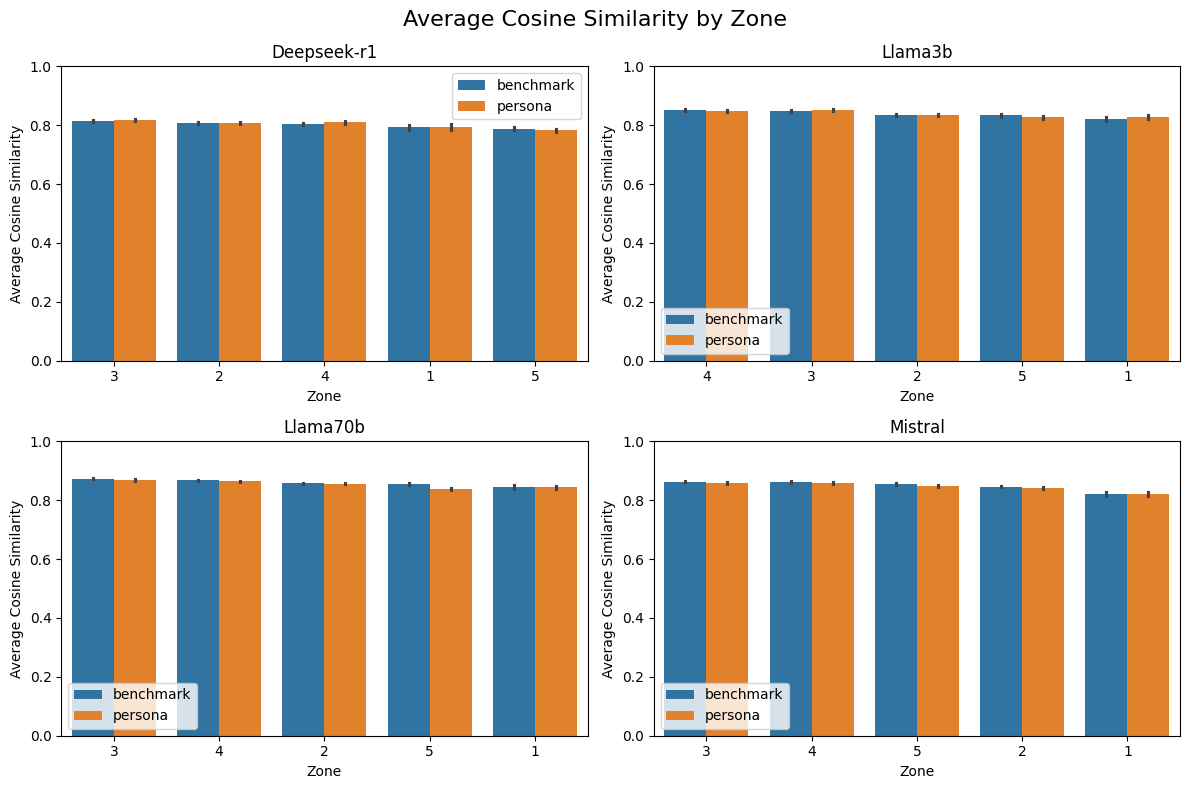

In [12]:
models = ["deepseek-r1", "llama3b", "llama70b", "mistral"]

plt.figure(figsize=(12, 8))
plt.suptitle("Average Cosine Similarity by Zone", fontsize=16)

for i, model in enumerate(models, 1):
    plt.subplot(2, 2, i)
    df_model = row_sim_filtered[row_sim_filtered['model'] == model].copy()

    df_diff = df_model[df_model['prompt'] == 'benchmark'].groupby('zone')[['similarity']].mean()
    df_diff_sorted = df_diff.sort_values(by='similarity', ascending=False).index
    sns.barplot(data=df_model, x="zone", y="similarity", hue="prompt", 
               order=df_diff_sorted, errorbar='ci', alpha=1)
    plt.title(f'{model.capitalize()}')
    plt.xlabel('Zone')
    plt.ylabel('Average Cosine Similarity')
    plt.xticks()#rotation=45, ha='right', fontsize=8)  # Adjust fontsize if needed
    plt.ylim(0,1)  # Set y-axis limit to [0, 1] for correct match rate
# Add the legend to the entire figure outside the loop
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:], labels[:])
plt.tight_layout()
plt.show()

In [13]:
row_sim_filtered_zone = row_sim_filtered.pivot_table(index=["zone", "model"], columns=["prompt"], values="similarity").reset_index()
# row_sim_filtered_zone = row_sim_filtered_zone[row_sim_filtered_zone['zone'] != 5]
row_sim_filtered_zone["difference"] = (row_sim_filtered_zone["persona"] - row_sim_filtered_zone["benchmark"])
# add a column for % difference, format in percentage and 3 decimal places


row_sim_filtered_zone["percent_difference"] = row_sim_filtered_zone["difference"] / row_sim_filtered_zone["benchmark"]
row_sim_filtered_zone["percent_difference"] = row_sim_filtered_zone["percent_difference"].apply(lambda x: f"{x:.3%}")


#restructure the DataFrame to have each 'model' a column
# row_sim_filtered_zone = row_sim_filtered_zone.pivot(index="zone", columns="model", values="difference").reset_index()
row_sim_filtered_zone = row_sim_filtered_zone.sort_values(by="difference", ascending=False)
row_sim_filtered_zone

prompt,zone,model,benchmark,persona,difference,percent_difference
1,1,llama3b,0.820643,0.827474,0.006831,0.832%
12,4,deepseek-r1,0.805185,0.809582,0.004397,0.546%
8,3,deepseek-r1,0.815147,0.818513,0.003366,0.413%
9,3,llama3b,0.847858,0.850698,0.002839,0.335%
0,1,deepseek-r1,0.792260,0.793960,0.001700,0.215%
5,2,llama3b,0.834027,0.834219,0.000192,0.023%
4,2,deepseek-r1,0.807400,0.806892,-0.000508,-0.063%
6,2,llama70b,0.857162,0.856401,-0.000762,-0.089%
3,1,mistral,0.821715,0.820439,-0.001276,-0.155%
2,1,llama70b,0.845484,0.843453,-0.002031,-0.240%


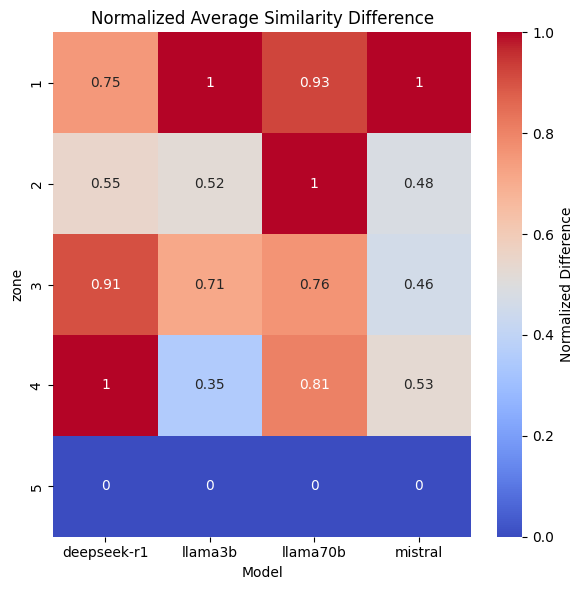

In [14]:
row_sim_filtered_zone = row_sim_filtered.pivot_table(index=["zone", "model"], columns=["prompt"], values="similarity").reset_index()
# row_sim_filtered_zone = row_sim_filtered_zone[row_sim_filtered_zone['zone'] != 5]
row_sim_filtered_zone["difference"] = (row_sim_filtered_zone["persona"] - row_sim_filtered_zone["benchmark"])
row_sim_filtered_zone["normalized_difference"] = row_sim_filtered_zone.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)
heatmap_data = row_sim_filtered_zone.pivot(index="zone", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Similarity Difference")
plt.xlabel("Model")
plt.ylabel("zone")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

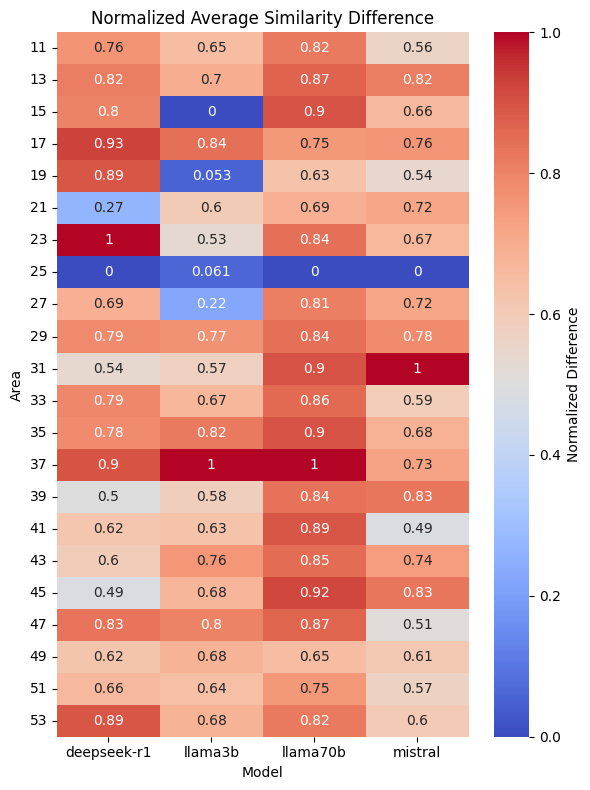

In [15]:
df_des_pivot = row_sim_filtered.groupby(['model', 'prompt', 'area'])['similarity'].mean().reset_index().pivot_table(index=["area", "model"], columns=["prompt"], values="similarity").reset_index()
# df_des_pivot = df_des_pivot[df_des_pivot['area'] != '25']
df_des_pivot["difference"] = (df_des_pivot["persona"] - df_des_pivot["benchmark"])
df_des_pivot["normalized_difference"] = df_des_pivot.groupby("model")["difference"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

plt.figure(figsize=(8, 6))
# sns.barplot(data=df_des_pivot, x="area", y="normalized_difference", hue="model")
# Pivot the data so that rows are area, columns are model, and values are normalized_difference
heatmap_data = df_des_pivot.pivot(index="area", columns="model", values="normalized_difference")

plt.figure(figsize=(6, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar_kws={'label': 'Normalized Difference'})
plt.title("Normalized Average Similarity Difference")
plt.xlabel("Model")
plt.ylabel("Area")
plt.tight_layout()
plt.yticks(rotation=0, ha='right', fontsize=10)  # Adjust fontsize if needed
plt.show()

### Compare Cosine distance

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Define function to compute upper triangle from cosine similarity matrix
def compute_similarity_structure(df, valid_codes=None):
    # Only keep codes that are in valid_codes (if provided)
    if valid_codes is not None:
        df = df[df['code'].isin(valid_codes)]
    codes = df['code'].unique()
    df = df.set_index('code').loc[codes]  # Ensure consistent ordering
    embeddings = np.stack(df['embedding'].values)
    cosine_sim = 1 - squareform(pdist(embeddings, metric='cosine'))
    upper_tri = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
    return upper_tri

# Extract unique models and prompts
models = df_all_embeddings['model'].unique()
prompts = ['ref', 'benchmark', 'persona']

# Store cosine similarity vectors
similarity_vectors = {}

# Loop through each iteration (assuming 0-9)
all_corrs = []
for iteration in range(10):
    similarity_vectors = {}
    for model in models:
        # Get codes present in all three prompts for this model/iteration
        codes_bench = set(df_all_embeddings[
            (df_all_embeddings['model'] == model) &
            (df_all_embeddings['prompt'] == 'benchmark') &
            (df_all_embeddings['iteration'] == iteration)
        ]['code'])
        codes_pers = set(df_all_embeddings[
            (df_all_embeddings['model'] == model) &
            (df_all_embeddings['prompt'] == 'persona') &
            (df_all_embeddings['iteration'] == iteration)
        ]['code'])
        codes_ref = set(df_all_embeddings[
            (df_all_embeddings['model'] == model) &
            (df_all_embeddings['prompt'] == 'ref') &
            (df_all_embeddings['iteration'] == iteration)
        ]['code'])
        # Only keep codes present in all three
        valid_codes = sorted(list(codes_bench & codes_pers & codes_ref))
        if len(valid_codes) < 2:
            continue  # Not enough codes to compute pairwise similarities

        # Get reference embeddings for only those codes
        df_ref = df_all_embeddings[
            (df_all_embeddings['model'] == model) &
            (df_all_embeddings['prompt'] == 'ref') &
            (df_all_embeddings['iteration'] == iteration) &
            (df_all_embeddings['code'].isin(valid_codes))
        ].groupby(['model', 'prompt', 'code', 'area'])['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()
        df_ref = df_ref.set_index('code').loc[valid_codes].reset_index()  # Ensure order

        sim_vec_ref = compute_similarity_structure(df_ref, valid_codes=valid_codes)
        similarity_vectors[(model, 'ref')] = sim_vec_ref

        for prompt in ['benchmark', 'persona']:
            df_sub = df_all_embeddings[
                (df_all_embeddings['model'] == model) &
                (df_all_embeddings['prompt'] == prompt) &
                (df_all_embeddings['iteration'] == iteration) &
                (df_all_embeddings['code'].isin(valid_codes))
            ]
            df_sub = df_sub.set_index('code').loc[valid_codes].reset_index()  # Ensure order
            sim_vec = compute_similarity_structure(df_sub, valid_codes=valid_codes)
            similarity_vectors[(model, prompt)] = sim_vec

    # Compare each model's benchmark/persona to ref for this iteration
    for model in models:
        if (model, 'ref') not in similarity_vectors:
            continue
        ref_vec = similarity_vectors[(model, 'ref')]
        for other_prompt in ['benchmark', 'persona']:
            if (model, other_prompt) not in similarity_vectors:
                continue
            other_vec = similarity_vectors[(model, other_prompt)]
            if len(ref_vec) != len(other_vec):
                print(f"Warning: Length mismatch for {model}, {other_prompt}, iteration {iteration}: {len(ref_vec)} vs {len(other_vec)}")
                continue
            rho, pval = spearmanr(ref_vec, other_vec)
            all_corrs.append({
                'iteration': iteration,
                'model': model,
                'comparison': other_prompt,
                'spearman_rho': rho,
                'p_value': pval
            })

# Output results
corr_df = pd.DataFrame(all_corrs)
corr_df


,iteration,model,comparison,spearman_rho,p_value
0,0,deepseek-r1,benchmark,0.598113,0.0
1,0,deepseek-r1,persona,0.607075,0.0
2,0,llama3b,benchmark,0.642477,0.0
3,0,llama3b,persona,0.658504,0.0
4,0,llama70b,benchmark,0.693647,0.0
...,...,...,...,...,...
75,9,llama3b,persona,0.656934,0.0
76,9,llama70b,benchmark,0.686033,0.0
77,9,llama70b,persona,0.695120,0.0
78,9,mistral,benchmark,0.676329,0.0


In [17]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# Define function to compute upper triangle from cosine similarity matrix
def compute_similarity_structure(df):
    codes = df['code'].unique()
    df = df.set_index('code').loc[codes]  # Ensure consistent ordering
    embeddings = np.stack(df['embedding'].values)
    cosine_sim = 1 - squareform(pdist(embeddings, metric='cosine'))
    upper_tri = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
    return upper_tri

# Extract unique models and prompts
models = df_all_embeddings_avg['model'].unique()
prompts = ['ref', 'benchmark', 'persona']

# Store cosine similarity vectors
similarity_vectors = {}

# Loop through each iteration (assuming 0-9)
all_corrs = []
for iteration in range(1):
    similarity_vectors = {}
    # Filter for current iteration for benchmark/persona, and use ref (iteration doesn't matter for ref)
    for model in models:
        # Get reference embeddings (unique per code)
        df_ref = df_all_embeddings_avg[(df_all_embeddings_avg['model'] == model) & (df_all_embeddings_avg['prompt'] == 'ref')].groupby(['model', 'prompt','code'])['embedding'].apply(lambda x: np.mean(np.stack(x), axis=0)).reset_index()
        sim_vec_ref = compute_similarity_structure(df_ref)
        similarity_vectors[(model, 'ref')] = sim_vec_ref

        for prompt in ['benchmark', 'persona']:
            df_sub = df_all_embeddings_avg[
                (df_all_embeddings_avg['model'] == model) &
                (df_all_embeddings_avg['prompt'] == prompt)
            ]
            sim_vec = compute_similarity_structure(df_sub)
            similarity_vectors[(model, prompt)] = sim_vec

    # Compare each model's benchmark/persona to ref for this iteration
    for model in models:
        ref_vec = similarity_vectors[(model, 'ref')]
        for other_prompt in ['benchmark', 'persona']:
            other_vec = similarity_vectors[(model, other_prompt)]
            rho, pval = spearmanr(ref_vec, other_vec)
            all_corrs.append({
                'iteration': iteration,
                'model': model,
                'comparison': other_prompt,
                'spearman_rho': rho,
                'p_value': pval
            })

# Output results
corr_df_avg = pd.DataFrame(all_corrs)
corr_df_avg



,iteration,model,comparison,spearman_rho,p_value
0,0,deepseek-r1,benchmark,0.683118,0.0
1,0,deepseek-r1,persona,0.699946,0.0
2,0,llama3b,benchmark,0.741425,0.0
3,0,llama3b,persona,0.733907,0.0
4,0,llama70b,benchmark,0.757869,0.0
5,0,llama70b,persona,0.733506,0.0
6,0,mistral,benchmark,0.743357,0.0
7,0,mistral,persona,0.733024,0.0


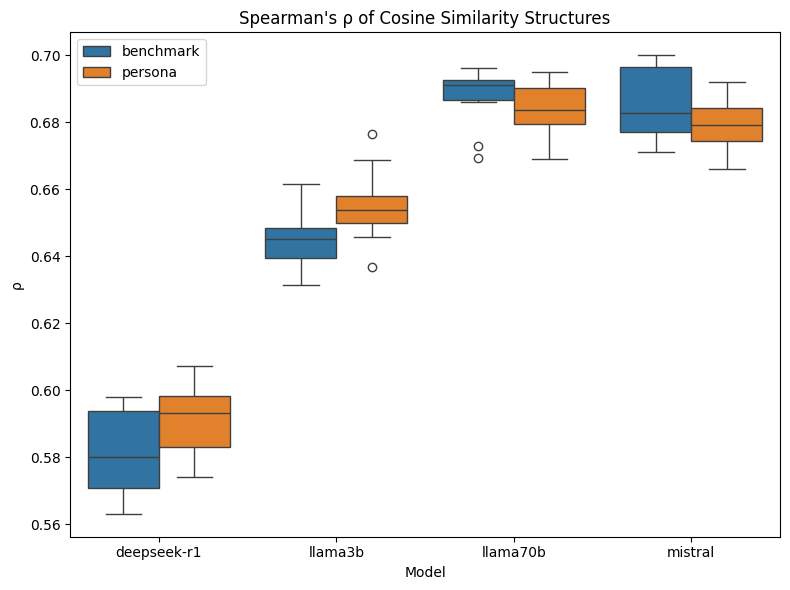

In [18]:
corr_df
# Plotting the Spearman correlation
plt.figure(figsize=(8, 6))
sns.boxplot(data=corr_df, x='model', y='spearman_rho', hue='comparison')
plt.title('Spearman\'s ρ of Cosine Similarity Structures')
plt.xlabel('Model')
plt.ylabel('ρ')
plt.tight_layout()
plt.legend()

### cohesion

cohesion by area

Cohesion per (Model, Prompt, Area) Group (using Cosine DISTANCE):
NOTE: For cohesion measured with distance, a LOWER score indicates BETTER cohesion.
           model     prompt area  cohesion_sum  num_points  average_cohesion
0    deepseek-r1  benchmark   11     11.163918          51          0.218900
1    deepseek-r1  benchmark   13     12.346362          43          0.287125
2    deepseek-r1  benchmark   15      7.675253          29          0.264664
3    deepseek-r1  benchmark   17     16.088141          55          0.292512
4    deepseek-r1  benchmark   19     21.782681          59          0.369198
..           ...        ...  ...           ...         ...               ...
259      mistral        ref   45      2.698329          12          0.224861
260      mistral        ref   47     17.205228          61          0.282053
261      mistral        ref   49     10.851666          50          0.217033
262      mistral        ref   51     26.120802         107          0.244120
263

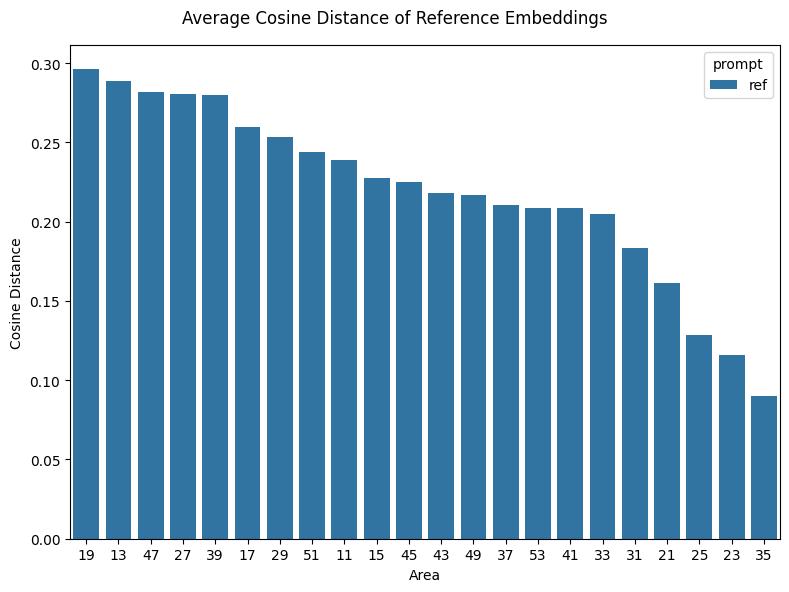

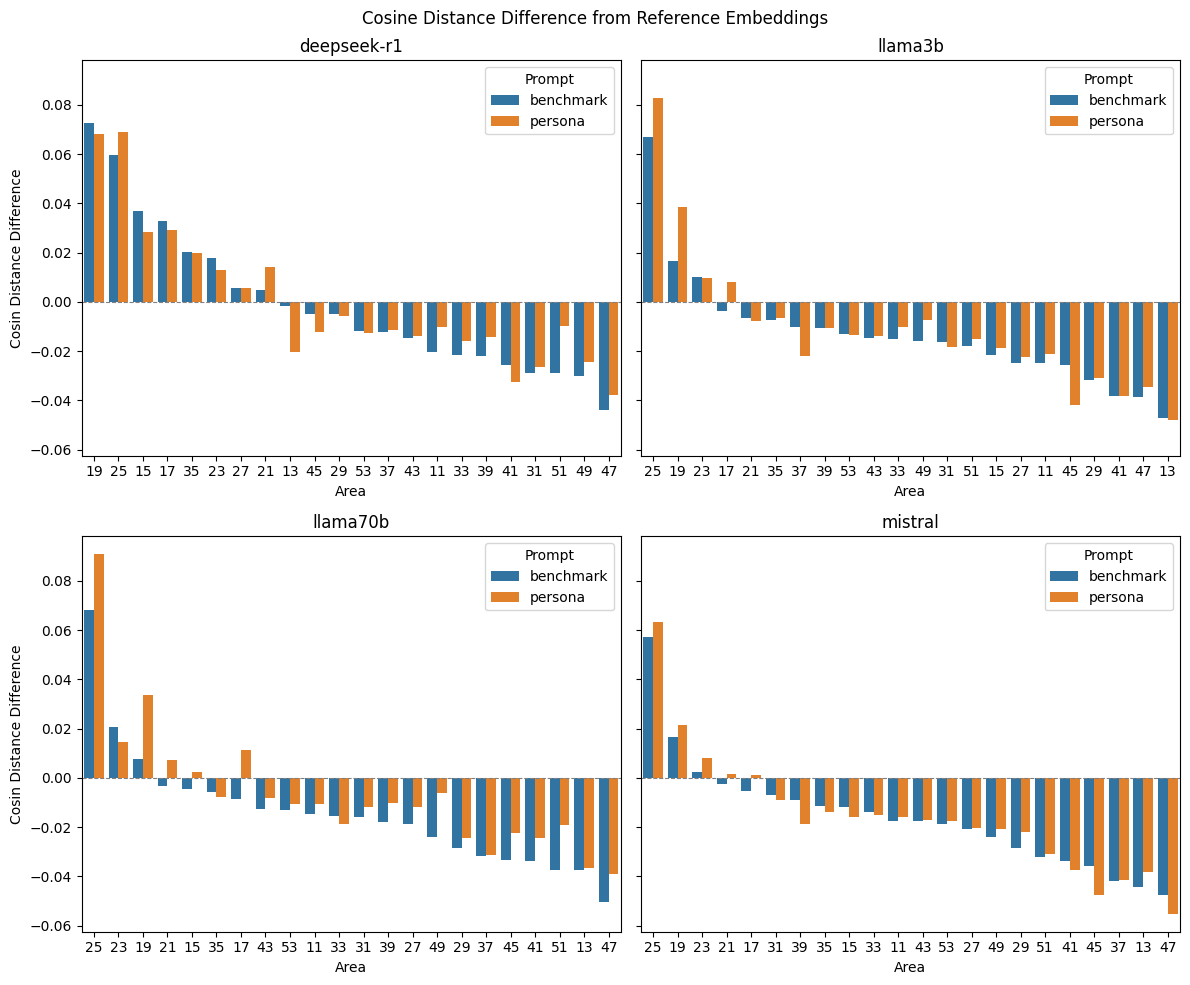

In [19]:
# Group by 'model', 'prompt', and 'area'
grouped = df_all_embeddings_avg.groupby(['model', 'prompt', 'area'])

# Initialize a list to store results
cohesion_results = []

for name, group in grouped:
    model_label, prompt_label, area_label = name
    
    if len(group) == 0:
        continue # Skip empty groups

    # Convert embeddings to a 2D NumPy array for scikit-learn's cosine_distances
    group_embeddings = np.array(group['embedding'].tolist())
    
    # Check if there's enough data to compute centroid and distances
    if len(group_embeddings) < 1: # Need at least one point to compute centroid
        continue
    
    # Calculate the centroid for the current group
    centroid = np.mean(group_embeddings, axis=0)
    
    # Reshape centroid to be a 2D array (1, n_features) as required by cosine_distances
    centroid_reshaped = centroid.reshape(1, -1)
    
    # Calculate cosine distances between all group embeddings and the centroid
    # --- IMPORTANT CHANGE HERE: Using cosine_distances ---
    distances = cosine_distances(group_embeddings, centroid_reshaped)
    
    # Sum these distances to get the total cohesion (sum of distances) for the group
    cohesion_sum = distances.sum()
        
    # Calculate the number of data points in this group
    num_points = len(group)
    
    # Calculate average cohesion (average distance) for this group
    average_cohesion = cohesion_sum / num_points if num_points > 0 else 0
    
    cohesion_results.append({
        'model': model_label,
        'prompt': prompt_label,
        'area': area_label,
        'cohesion_sum': cohesion_sum,
        'num_points': num_points,
        'average_cohesion': average_cohesion
    })

# Convert results to a DataFrame for easier analysis
cohesion_df = pd.DataFrame(cohesion_results)

# --- 3. Display Results ---
print("Cohesion per (Model, Prompt, Area) Group (using Cosine DISTANCE):")
print("NOTE: For cohesion measured with distance, a LOWER score indicates BETTER cohesion.")
print(cohesion_df)

print("\n--- Comparing Cohesion for Persona vs. Benchmark (against Ref) by Model and Area ---")
print("NOTE: 'cohesion_vs_ref_diff' will be negative if the prompt's cohesion is BETTER (lower distance) than 'ref'.")

# Filter for the relevant prompts
comparison_df = cohesion_df[cohesion_df['prompt'].isin(['persona', 'benchmark', 'ref'])].copy()

# Get 'ref' cohesion values, indexed by 'model' and 'area'
ref_cohesion = comparison_df[comparison_df['prompt'] == 'ref'].set_index(['model', 'area'])[['average_cohesion']].rename(columns={'average_cohesion': 'ref_cohesion'})

# Merge ref cohesion into the comparison_df (for persona and benchmark rows)
merged_comparison = pd.merge(
    comparison_df,#[comparison_df['prompt'] != 'ref'],
    ref_cohesion,
    on=['model', 'area'], # Merge on both model and area
    how='left'
)

# Calculate the difference relative to 'ref'
# A negative difference here means the current prompt's cohesion (distance) is LOWER than ref's, which is BETTER.
merged_comparison['cohesion_vs_ref_diff'] = merged_comparison['average_cohesion'] - merged_comparison['ref_cohesion']

print(merged_comparison)

# Display the comparison
print("\nComparison of Persona/Benchmark Cohesion vs. Ref Cohesion (Difference = Prompt Cohesion - Ref Cohesion):")
print(merged_comparison)

# Optional: Pivot the merged_comparison to see side-by-side differences
# for persona and benchmark for each model and area.
pivot_comparison = merged_comparison.pivot_table(
    index=['model', 'area'], # Index by both model and area
    columns='prompt',
    values=['average_cohesion', 'cohesion_vs_ref_diff']
)
print("\nPivoted Comparison Table:")
print(pivot_comparison)


# --- 4. Visualizations ---
# Ensure 'area' is treated as a categorical variable for plotting if desired
merged_comparison['area_str'] = merged_comparison['area'].astype(str)
#pl;ot 1: Average Cohesion per (Model, Area) by Prompt
plt.figure(figsize=(8, 6))
data = merged_comparison[merged_comparison['prompt'] == 'ref']
data_order = merged_comparison[merged_comparison['prompt'] == 'ref'].groupby('area_str')['average_cohesion'].mean().sort_values(ascending=False).index
sns.barplot(data=data, x='area_str', y='average_cohesion', hue='prompt', order=data_order)

plt.suptitle('Average Cosine Distance of Reference Embeddings')
plt.xlabel('Area')
plt.ylabel('Cosine Distance')
plt.tight_layout()#rect=[0, 0, 1, 0.98])
plt.show()

# Plot 2: Difference in Average Cohesion (Prompt - Ref) per (Model, Area)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
models = merged_comparison['model'].unique()
for ax, model in zip(axes.flatten(), models):
    data = merged_comparison[(merged_comparison['model'] == model) & (merged_comparison['prompt'] != 'ref')]
    diff = data[data['prompt'] == 'benchmark'].groupby('area_str')['cohesion_vs_ref_diff'].mean().sort_values(ascending=False).index
    sns.barplot(data=data, x='area_str', y='cohesion_vs_ref_diff', hue='prompt', order=diff, ax=ax)
    ax.set_title(f"{model}")
    ax.set_ylabel('Cosin Distance Difference')
    ax.set_xlabel('Area')
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.legend(title='Prompt')
plt.suptitle('Cosine Distance Difference from Reference Embeddings')
plt.tight_layout()#rect=[0, 0, 1, 0.98])
plt.show()


In [20]:
pivot_comparison['average_cohesion'].iloc[:22].sort_values(by='ref', ascending=False)

prompt            benchmark   persona       ref
model       area                               
deepseek-r1 19     0.369198  0.364833  0.296654
            13     0.287125  0.268671  0.288843
            47     0.238037  0.244083  0.282053
            27     0.285796  0.285979  0.280266
            39     0.258074  0.265634  0.279886
            17     0.292512  0.288710  0.259697
            29     0.248661  0.247777  0.253499
            51     0.215141  0.234306  0.244120
            11     0.218900  0.228894  0.239170
            15     0.264664  0.256153  0.227848
            45     0.220145  0.212520  0.224861
            43     0.203881  0.204499  0.218339
            49     0.186915  0.192858  0.217033
            37     0.198247  0.199316  0.210520
            53     0.196838  0.196123  0.208696
            41     0.183050  0.175974  0.208445
            33     0.183453  0.189331  0.205044
            31     0.154897  0.157235  0.183554
            21     0.166257  0.175351  0.161322
            25     0.188511  0.197464  0.128658
            23     0.133940  0.129141  0.116214
            35     0.110245  0.109653  0.089881

Cohesion by zone

Cohesion per (Model, Prompt, zone) Group:
          model     prompt  zone  cohesion_sum  num_points  average_cohesion
0   deepseek-r1  benchmark     1     21.991136          31          0.709391
1   deepseek-r1  benchmark     2    204.071671         285          0.716041
2   deepseek-r1  benchmark     3    145.831702         209          0.697759
3   deepseek-r1  benchmark     4    133.793539         204          0.655851
4   deepseek-r1  benchmark     5     96.540058         150          0.643600
5   deepseek-r1    persona     1     21.897148          31          0.706360
6   deepseek-r1    persona     2    201.063033         285          0.705484
7   deepseek-r1    persona     3    145.168166         209          0.694585
8   deepseek-r1    persona     4    134.698042         204          0.660285
9   deepseek-r1    persona     5     96.529385         150          0.643529
10  deepseek-r1        ref     1     21.416120          31          0.690843
11  deepseek-r1        ref     2  

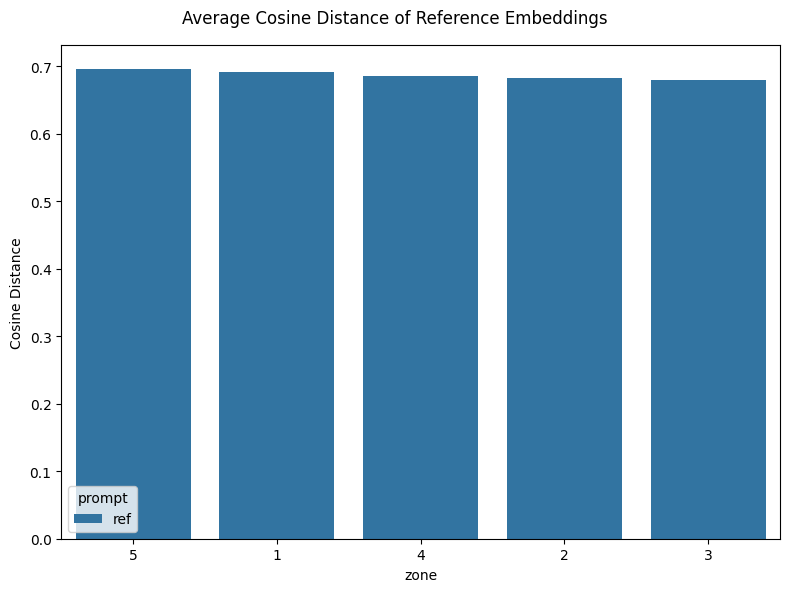

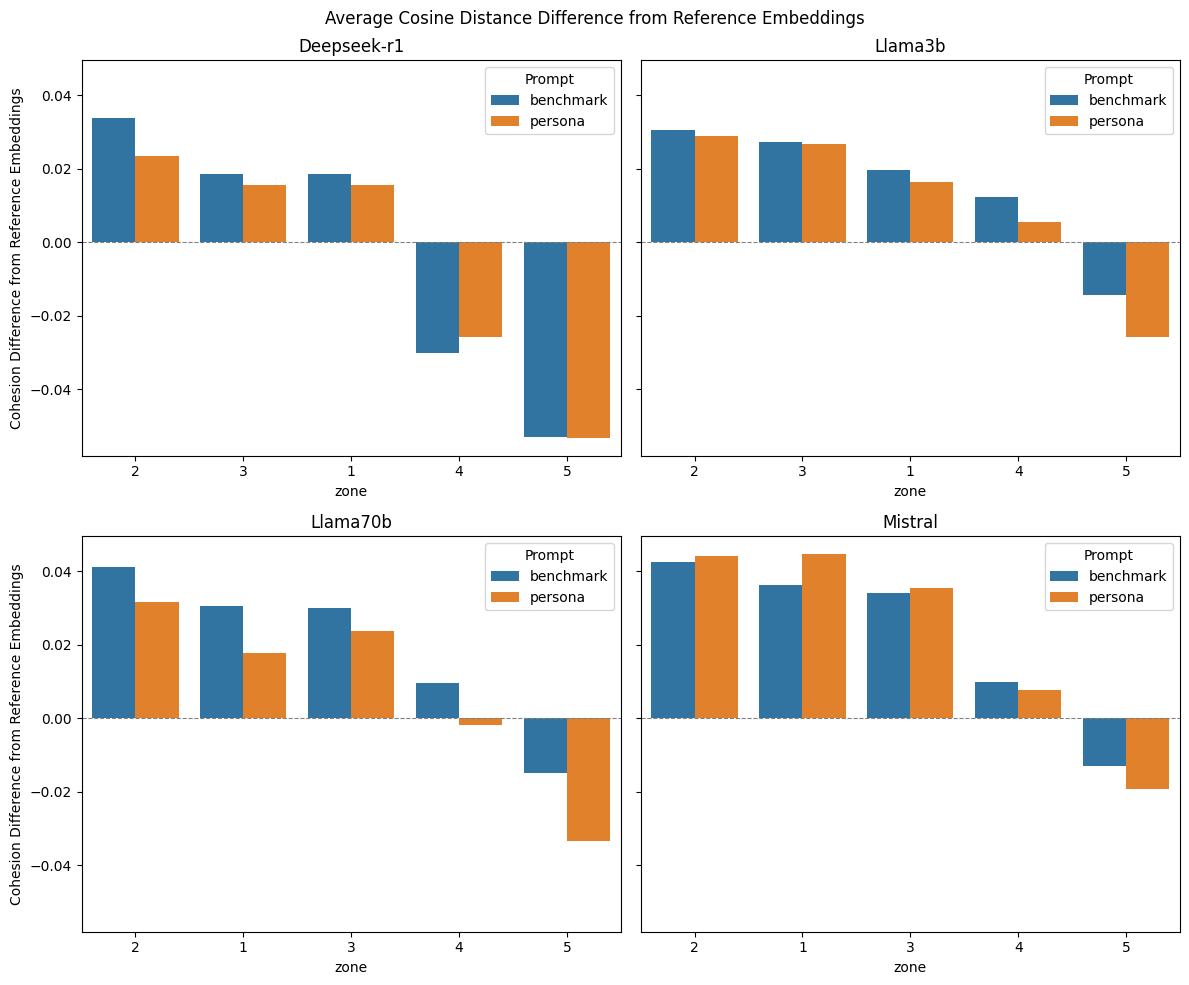

In [21]:
# Group by 'model', 'prompt', and 'zone'
grouped = df_all_embeddings_avg.groupby(['model', 'prompt', 'zone'])

# Initialize a list to store results
cohesion_results = []

for name, group in grouped:
    model_label, prompt_label, zone_label = name
    
    if len(group) == 0:
        continue # Skip empty groups

    # Convert embeddings to a 2D NumPy array for scikit-learn's cosine_similarity
    group_embeddings = np.array(group['embedding'].tolist())
    
    # Calculate the centroid for the current group
    centroid = np.mean(group_embeddings, axis=0)
    
    # Reshape centroid to be a 2D array (1, n_features) as required by cosine_similarity
    centroid_reshaped = centroid.reshape(1, -1)
    
    # Calculate cosine similarities between all group embeddings and the centroid
    similarities = cosine_similarity(group_embeddings, centroid_reshaped)
    
    # Sum these similarities to get the total cohesion for the group
    cohesion_sum = similarities.sum()
        
    # Calculate the number of data points in this group
    num_points = len(group)
    
    # Calculate average cohesion for this group
    average_cohesion = cohesion_sum / num_points if num_points > 0 else 0
    
    cohesion_results.append({
        'model': model_label,
        'prompt': prompt_label,
        'zone': zone_label,
        'cohesion_sum': cohesion_sum,
        'num_points': num_points,
        'average_cohesion': average_cohesion
    })

# Convert results to a DataFrame for easier analysis
cohesion_df = pd.DataFrame(cohesion_results)

# --- 3. Display Results ---
print("Cohesion per (Model, Prompt, zone) Group:")
print(cohesion_df)

print("\n--- Comparing Cohesion for Persona vs. Benchmark (against Ref) by Model and zone ---")

# Filter for the relevant prompts
comparison_df = cohesion_df[cohesion_df['prompt'].isin(['persona', 'benchmark', 'ref'])].copy()

# Get 'ref' cohesion values, indexed by 'model' and 'zone'
ref_cohesion = comparison_df[comparison_df['prompt'] == 'ref'].set_index(['model', 'zone'])[['average_cohesion']].rename(columns={'average_cohesion': 'ref_cohesion'})

# Merge ref cohesion into the comparison_df (for persona and benchmark rows)
merged_comparison = pd.merge(
    comparison_df,
    ref_cohesion,
    on=['model', 'zone'], # Merge on both model and zone
    how='left'
)

# Calculate the difference relative to 'ref'
merged_comparison['cohesion_vs_ref_diff'] = merged_comparison['average_cohesion'] - merged_comparison['ref_cohesion']


# Display the comparison
print("\nComparison of Persona/Benchmark Cohesion vs. Ref Cohesion (Difference = Prompt Cohesion - Ref Cohesion):")
print(merged_comparison)

# Optional: Pivot the merged_comparison to see side-by-side differences
# for persona and benchmark for each model and zone.
pivot_comparison = merged_comparison.pivot_table(
    index=['model', 'zone'], # Index by both model and zone
    columns='prompt',
    values=['average_cohesion', 'cohesion_vs_ref_diff']
)
print("\nPivoted Comparison Table:")
print(pivot_comparison)


# --- 4. Visualizations ---
# Ensure 'zone' is treated as a categorical variable for plotting if desired
cohesion_df['zone_str'] = cohesion_df['zone'].astype(str)
merged_comparison['zone_str'] = merged_comparison['zone'].astype(str)


# --- 4. Visualizations ---
# Ensure 'zone' is treated as a categorical variable for plotting if desired
merged_comparison['zone_str'] = merged_comparison['zone'].astype(str)
#pl;ot 1: Average Cohesion per (Model, zone) by Prompt
plt.figure(figsize=(8, 6))
data = merged_comparison[merged_comparison['prompt'] == 'ref']
sns.barplot(data=data, x='zone_str', y='average_cohesion', hue='prompt', order=data.groupby('zone_str')['average_cohesion'].mean().sort_values(ascending=False).index)

plt.suptitle('Average Cosine Distance of Reference Embeddings')
plt.xlabel('zone')
plt.ylabel('Cosine Distance')
plt.tight_layout()
plt.show()

# Plot 2: Difference in Average Cohesion (Prompt - Ref) per (Model, zone)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
models = merged_comparison['model'].unique()
for ax, model in zip(axes.flatten(), models):
    data = merged_comparison[(merged_comparison['model'] == model) & (merged_comparison['prompt'] != 'ref')]
    diff = data[data['prompt'] == 'benchmark'].groupby('zone_str')['cohesion_vs_ref_diff'].mean().sort_values(ascending=False).index
    sns.barplot(data=data, x='zone_str', y='cohesion_vs_ref_diff', hue='prompt', order=diff, ax=ax)
    ax.set_title(f"{model.capitalize()}")
    ax.set_ylabel('Cohesion Difference from Reference Embeddings')
    ax.set_xlabel('zone')
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.legend(title='Prompt')
plt.suptitle('Average Cosine Distance Difference from Reference Embeddings')
plt.tight_layout()
plt.show()


### CCI

In [22]:
model_groups = df_all_embeddings_avg.groupby(['model', 'prompt'])

cci_results = []

for model_name, model_data in model_groups:
    print(f"\n--- Processing Model: {model_name} ---")

    # Define the clusters within this model's data using the 'area' column
    clusters = model_data['area'].unique()
    
    if len(clusters) < 2:
        print(f"  Skipping {model_name}: Less than 2 distinct clusters found. Cannot calculate CCI.")
        cci_results.append({
            'model': model_name,
            'C': np.nan,
            'S': np.nan,
            'CCI': np.nan,
            'num_clusters': len(clusters)
        })
        continue

    # --- Step 2.1: Calculate Intra-cluster Cohesion (C) ---
    C_total = 0.0
    cluster_centroids = {} # Store centroids for S calculation

    for cluster_id in clusters:
        # Get data points for the current cluster
        cluster_points_df = model_data[model_data['area'] == cluster_id]
        
        if len(cluster_points_df) == 0:
            continue # Skip empty clusters

        cluster_embeddings = np.array(cluster_points_df['embedding'].tolist())
        
        # Calculate cluster centroid
        centroid = np.mean(cluster_embeddings, axis=0)
        cluster_centroids[cluster_id] = centroid
        
        # Reshape centroid for cosine_distances function
        centroid_reshaped = centroid.reshape(1, -1)
        
        # Calculate sum of cosine_distances of points to their centroid for this cluster
        # Using cosine_distances instead of cosine_similarity
        cohesion_sum_cluster = cosine_distances(cluster_embeddings, centroid_reshaped).sum()
        C_total += cohesion_sum_cluster

    # --- Step 2.2: Calculate Inter-cluster Separation (S) ---
    S_total = 0.0
    # Iterate through all unique pairs of clusters
    sorted_clusters = sorted(cluster_centroids.keys()) # Ensure consistent order
    num_unique_clusters = len(sorted_clusters)

    if num_unique_clusters < 2:
        S_total = 0.0 # No pairs to compare
    else:
        for i in range(num_unique_clusters):
            for j in range(i + 1, num_unique_clusters):
                centroid_i = cluster_centroids[sorted_clusters[i]]
                centroid_j = cluster_centroids[sorted_clusters[j]]
                
                # Reshape centroids for cosine_distances
                centroid_i_reshaped = centroid_i.reshape(1, -1)
                centroid_j_reshaped = centroid_j.reshape(1, -1)
                
                # Calculate cosine_distances between centroids
                # Using cosine_distances instead of cosine_similarity
                S_total += cosine_distances(centroid_i_reshaped, centroid_j_reshaped)[0, 0] # [0,0] to get scalar

    # --- Step 2.3: Calculate CCI ---
    cci_value = np.nan
    if C_total + S_total != 0: # Avoid division by zero
        cci_value = S_total / (C_total + S_total)
    
    print(f"  Calculated C (sum of intra-cluster distances): {C_total:.4f}")
    print(f"  Calculated S (sum of inter-cluster distances): {S_total:.4f}")
    print(f"  Calculated CCI: {cci_value:.4f}")

    cci_results.append({
        'model': model_name,
        'C': C_total,
        'S': S_total,
        'CCI': cci_value,
        'num_clusters': num_unique_clusters
    })

# Convert results to a DataFrame
cci_area = pd.DataFrame(cci_results)

# Convert results to a DataFrame
cci_area = pd.DataFrame(cci_results)
cci_area['prompt'] = cci_area['model'].apply(lambda x: x[1])  # Extract prompt type from model name
cci_area['model'] = cci_area['model'].apply(lambda x: x[0])  # Extract model name from tuple

cci_area



--- Processing Model: ('deepseek-r1', 'benchmark') ---
  Calculated C (sum of intra-cluster distances): 205.2095
  Calculated S (sum of inter-cluster distances): 69.0213
  Calculated CCI: 0.2517

--- Processing Model: ('deepseek-r1', 'persona') ---
  Calculated C (sum of intra-cluster distances): 207.6397
  Calculated S (sum of inter-cluster distances): 69.0436
  Calculated CCI: 0.2495

--- Processing Model: ('deepseek-r1', 'ref') ---
  Calculated C (sum of intra-cluster distances): 206.3205
  Calculated S (sum of inter-cluster distances): 65.9267
  Calculated CCI: 0.2422

--- Processing Model: ('llama3b', 'benchmark') ---
  Calculated C (sum of intra-cluster distances): 194.8354
  Calculated S (sum of inter-cluster distances): 64.4169
  Calculated CCI: 0.2485

--- Processing Model: ('llama3b', 'persona') ---
  Calculated C (sum of intra-cluster distances): 198.9462
  Calculated S (sum of inter-cluster distances): 64.2107
  Calculated CCI: 0.2440

--- Processing Model: ('llama3b', 're

,model,C,S,CCI,num_clusters,prompt
0,deepseek-r1,205.209505,69.021319,0.251691,22,benchmark
1,deepseek-r1,207.639688,69.043607,0.249540,22,persona
2,deepseek-r1,206.320460,65.926706,0.242158,22,ref
3,llama3b,194.835391,64.416882,0.248472,22,benchmark
4,llama3b,198.946164,64.210694,0.244002,22,persona
5,llama3b,206.320460,65.926706,0.242158,22,ref
6,llama70b,192.773294,63.321562,0.247258,22,benchmark
7,llama70b,202.198467,64.117196,0.240756,22,persona
8,llama70b,206.320460,65.926706,0.242158,22,ref
9,mistral,192.470837,61.584221,0.242405,22,benchmark


In [23]:
model_groups = df_all_embeddings_avg.groupby(['model', 'prompt'])

cci_results = []

for model_name, model_data in model_groups:
    print(f"\n--- Processing Model: {model_name} ---")

    # Define the clusters within this model's data using the 'zone' column
    clusters = model_data['zone'].unique()
    
    if len(clusters) < 2:
        print(f"  Skipping {model_name}: Less than 2 distinct clusters found. Cannot calculate CCI.")
        cci_results.append({
            'model': model_name,
            'C': np.nan,
            'S': np.nan,
            'CCI': np.nan,
            'num_clusters': len(clusters)
        })
        continue

    # --- Step 2.1: Calculate Intra-cluster Cohesion (C) ---
    C_total = 0.0
    cluster_centroids = {} # Store centroids for S calculation

    for cluster_id in clusters:
        # Get data points for the current cluster
        cluster_points_df = model_data[model_data['zone'] == cluster_id]
        
        if len(cluster_points_df) == 0:
            continue # Skip empty clusters

        cluster_embeddings = np.array(cluster_points_df['embedding'].tolist())
        
        # Calculate cluster centroid
        centroid = np.mean(cluster_embeddings, axis=0)
        cluster_centroids[cluster_id] = centroid
        
        # Reshape centroid for cosine_distances function
        centroid_reshaped = centroid.reshape(1, -1)
        
        # Calculate sum of cosine_distances of points to their centroid for this cluster
        # Using cosine_distances instead of cosine_similarity
        cohesion_sum_cluster = cosine_distances(cluster_embeddings, centroid_reshaped).sum()
        C_total += cohesion_sum_cluster

    # --- Step 2.2: Calculate Inter-cluster Separation (S) ---
    S_total = 0.0
    # Iterate through all unique pairs of clusters
    sorted_clusters = sorted(cluster_centroids.keys()) # Ensure consistent order
    num_unique_clusters = len(sorted_clusters)

    if num_unique_clusters < 2:
        S_total = 0.0 # No pairs to compare
    else:
        for i in range(num_unique_clusters):
            for j in range(i + 1, num_unique_clusters):
                centroid_i = cluster_centroids[sorted_clusters[i]]
                centroid_j = cluster_centroids[sorted_clusters[j]]
                
                # Reshape centroids for cosine_distances
                centroid_i_reshaped = centroid_i.reshape(1, -1)
                centroid_j_reshaped = centroid_j.reshape(1, -1)
                
                # Calculate cosine_distances between centroids
                # Using cosine_distances instead of cosine_similarity
                S_total += cosine_distances(centroid_i_reshaped, centroid_j_reshaped)[0, 0] # [0,0] to get scalar

    # --- Step 2.3: Calculate CCI ---
    cci_value = np.nan
    if C_total + S_total != 0: # Avoid division by zero
        cci_value = S_total / (C_total + S_total)
    
    print(f"  Calculated C (sum of intra-cluster distances): {C_total:.4f}")
    print(f"  Calculated S (sum of inter-cluster distances): {S_total:.4f}")
    print(f"  Calculated CCI: {cci_value:.4f}")

    cci_results.append({
        'model': model_name,
        'C': C_total,
        'S': S_total,
        'CCI': cci_value,
        'num_clusters': num_unique_clusters
    })

# Convert results to a DataFrame
cci_zone = pd.DataFrame(cci_results)

# Convert results to a DataFrame
cci_zone = pd.DataFrame(cci_results)
cci_zone['prompt'] = cci_zone['model'].apply(lambda x: x[1])  # Extract prompt type from model name
cci_zone['model'] = cci_zone['model'].apply(lambda x: x[0])  # Extract model name from tuple

cci_zone



--- Processing Model: ('deepseek-r1', 'benchmark') ---
  Calculated C (sum of intra-cluster distances): 276.7719
  Calculated S (sum of inter-cluster distances): 1.3897
  Calculated CCI: 0.0050

--- Processing Model: ('deepseek-r1', 'persona') ---
  Calculated C (sum of intra-cluster distances): 279.6442
  Calculated S (sum of inter-cluster distances): 1.3445
  Calculated CCI: 0.0048

--- Processing Model: ('deepseek-r1', 'ref') ---
  Calculated C (sum of intra-cluster distances): 276.8253
  Calculated S (sum of inter-cluster distances): 1.3234
  Calculated CCI: 0.0048

--- Processing Model: ('llama3b', 'benchmark') ---
  Calculated C (sum of intra-cluster distances): 261.3913
  Calculated S (sum of inter-cluster distances): 1.2624
  Calculated CCI: 0.0048

--- Processing Model: ('llama3b', 'persona') ---
  Calculated C (sum of intra-cluster distances): 265.1802
  Calculated S (sum of inter-cluster distances): 1.2557
  Calculated CCI: 0.0047

--- Processing Model: ('llama3b', 'ref') -

,model,C,S,CCI,num_clusters,prompt
0,deepseek-r1,276.771894,1.389676,0.004996,5,benchmark
1,deepseek-r1,279.644227,1.344528,0.004785,5,persona
2,deepseek-r1,276.825294,1.323368,0.004758,5,ref
3,llama3b,261.391331,1.262361,0.004806,5,benchmark
4,llama3b,265.180165,1.255726,0.004713,5,persona
5,llama3b,276.825294,1.323368,0.004758,5,ref
6,llama70b,258.089986,1.216711,0.004692,5,benchmark
7,llama70b,267.665394,1.249940,0.004648,5,persona
8,llama70b,276.825294,1.323368,0.004758,5,ref
9,mistral,256.382714,1.139948,0.004427,5,benchmark


Text(33.722222222222214, 0.5, 'CCI difference')

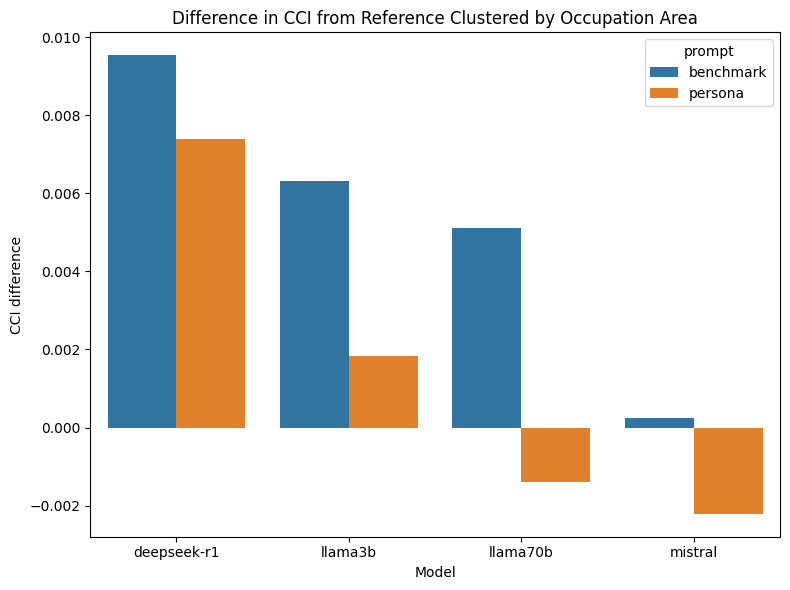

In [24]:
# plot cci_df
cci_data = cci_area.copy()
# Map the 'ref' CCI value for each model to all rows of that model
ref_map = cci_data[cci_data['prompt'] == 'ref'].set_index('model')['CCI']
cci_data['ref'] = cci_data['model'].map(ref_map)
cci_data['difference'] = cci_data['CCI'] - cci_data['ref']
cci_data = cci_data[cci_data['prompt'] != 'ref']

plt.figure(figsize=(8, 6))
sns.barplot(data=cci_data, x='model', y='difference', hue='prompt')
plt.title('Difference in CCI from Reference Clustered by Occupation Area')
plt.xlabel('Model')
plt.tight_layout()
plt.ylabel('CCI difference')

Text(24.847222222222214, 0.5, 'CCI Difference')

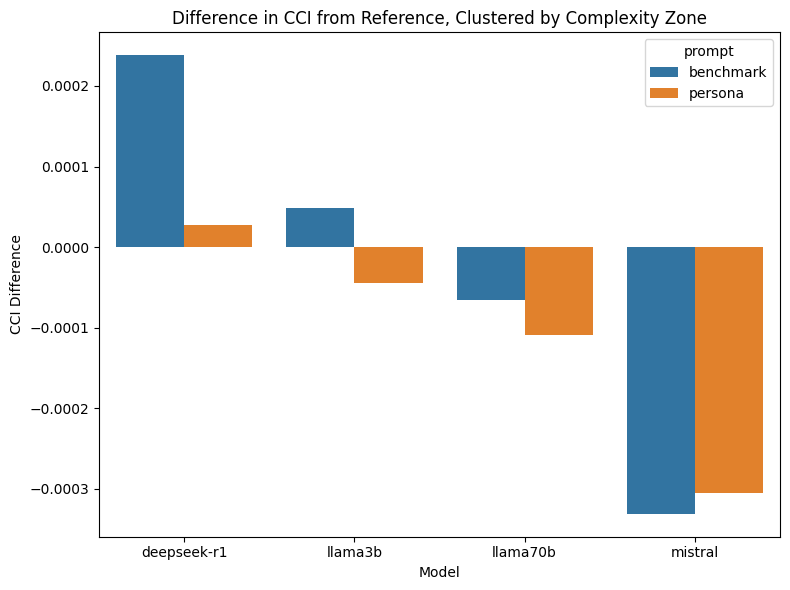

In [25]:
# plot cci_df
cci_data = cci_zone.copy()
# Map the 'ref' CCI value for each model to all rows of that model
ref_map = cci_data[cci_data['prompt'] == 'ref'].set_index('model')['CCI']
cci_data['ref'] = cci_data['model'].map(ref_map)
cci_data['difference'] = cci_data['CCI'] - cci_data['ref']
cci_data = cci_data[cci_data['prompt'] != 'ref']

plt.figure(figsize=(8, 6))
sns.barplot(data=cci_data, x='model', y='difference', hue='prompt')
plt.title('Difference in CCI from Reference, Clustered by Complexity Zone')
plt.xlabel('Model')
plt.tight_layout()
plt.ylabel('CCI Difference')

### Clustering

In [26]:
ref_embeddings_df = df_all_embeddings[df_all_embeddings['prompt']=='ref'].drop_duplicates(subset=['code']).set_index('code')
ref_embs_norm = np.stack(ref_embeddings_df['embedding'].values)

Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.

Optimal k by Silhouette Score: 30 (Score: 0.5559)
------------------------------


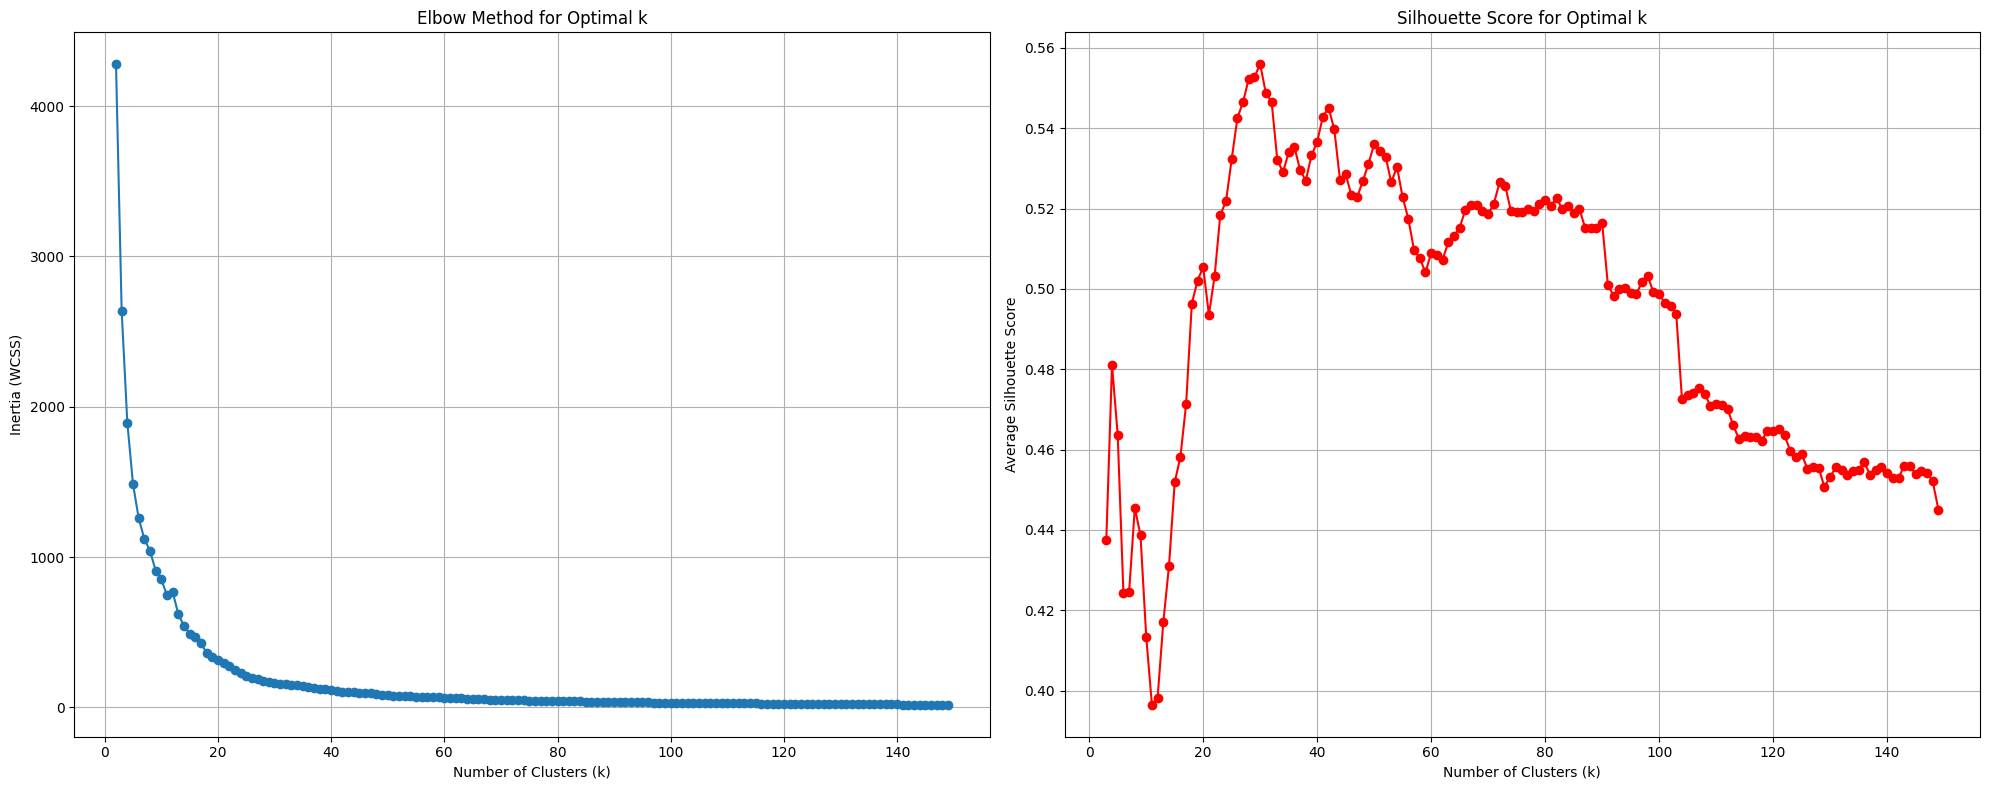

In [27]:
n_components = 10
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0.05,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

ref_embs_reduced = reducer.transform(ref_embs_norm)
k_range = range(2, min(300, 150)) # Test up to num_jobs or a reasonable upper bound

inertia_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(ref_embs_reduced)
    ref_cluster_labels_plot = kmeans.labels_


    # --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
    code_to_ref_cluster = {}
    for i, code in enumerate(ref_embeddings_df.index):
        code_to_ref_cluster[code] = ref_cluster_labels_plot[i]
    
    # Store inertia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate Silhouette Score (only if k > 1)
    if k > 1:
        score = silhouette_score(ref_embs_reduced, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Placeholder for k=1, where silhouette is undefined


# Find k with highest Silhouette Score (excluding NaN for k=1)
if len(silhouette_scores) > 1:
    best_k_silhouette = k_range[np.nanargmax(silhouette_scores)]
    print(f"\nOptimal k by Silhouette Score: {best_k_silhouette} (Score: {np.nanmax(silhouette_scores):.4f})")
else:
    print("\nNot enough k values to calculate meaningful Silhouette Scores.")

print("-" * 30)

# --- Plotting Elbow Method ---
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# --- Plotting Silhouette Scores ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Adjust k_range for silhouette scores since it starts from k=2
plt.plot(list(k_range)[1:], silhouette_scores[1:], marker='o', color='red') 
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


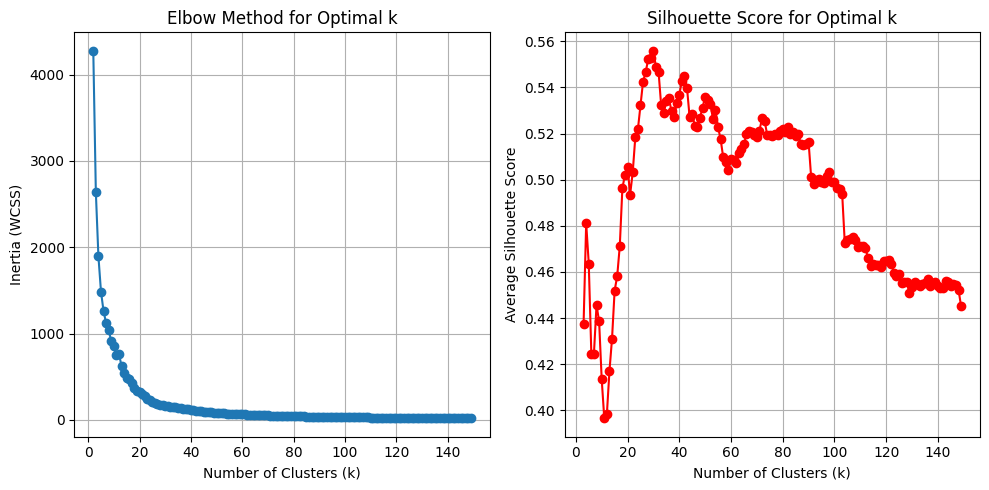

In [28]:
# --- Plotting Elbow Method ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# --- Plotting Silhouette Scores ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Adjust k_range for silhouette scores since it starts from k=2
plt.plot(list(k_range)[1:], silhouette_scores[1:], marker='o', color='red') 
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


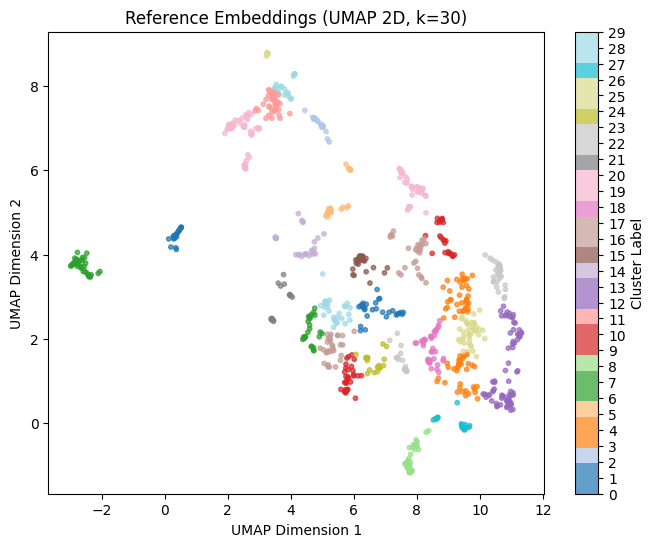

Processing model: deepseek-r1


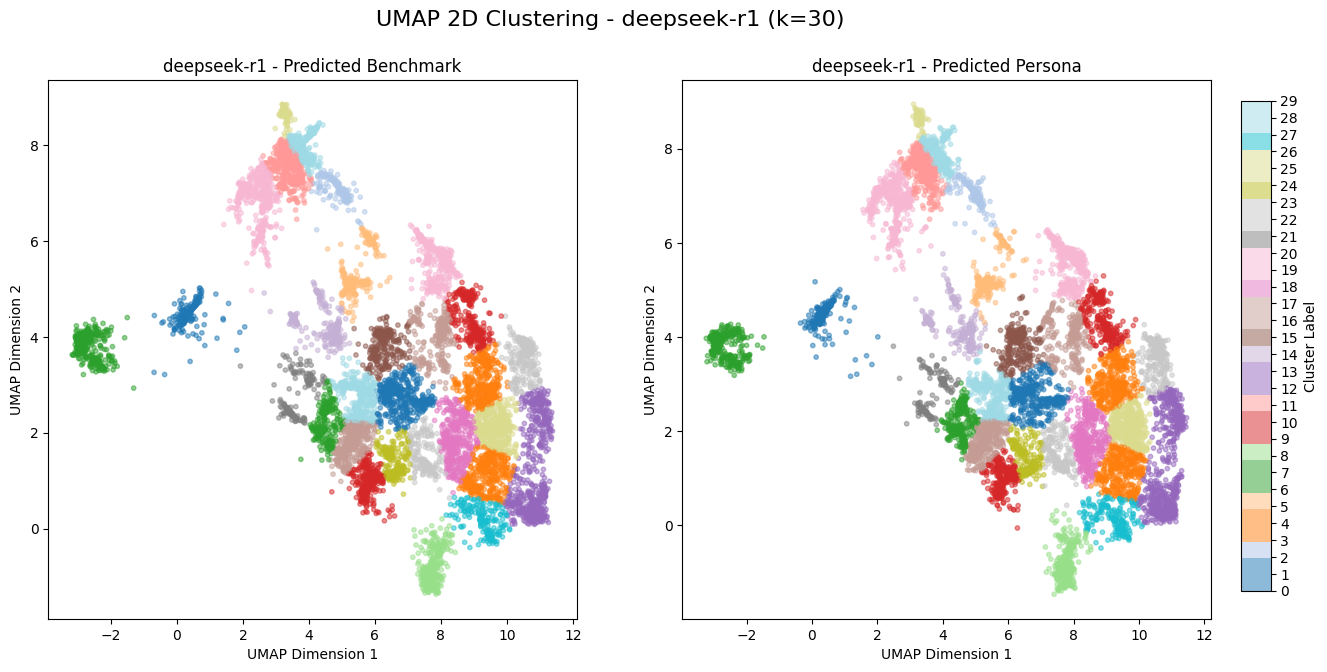

----------------------------------------
Processing model: llama3b


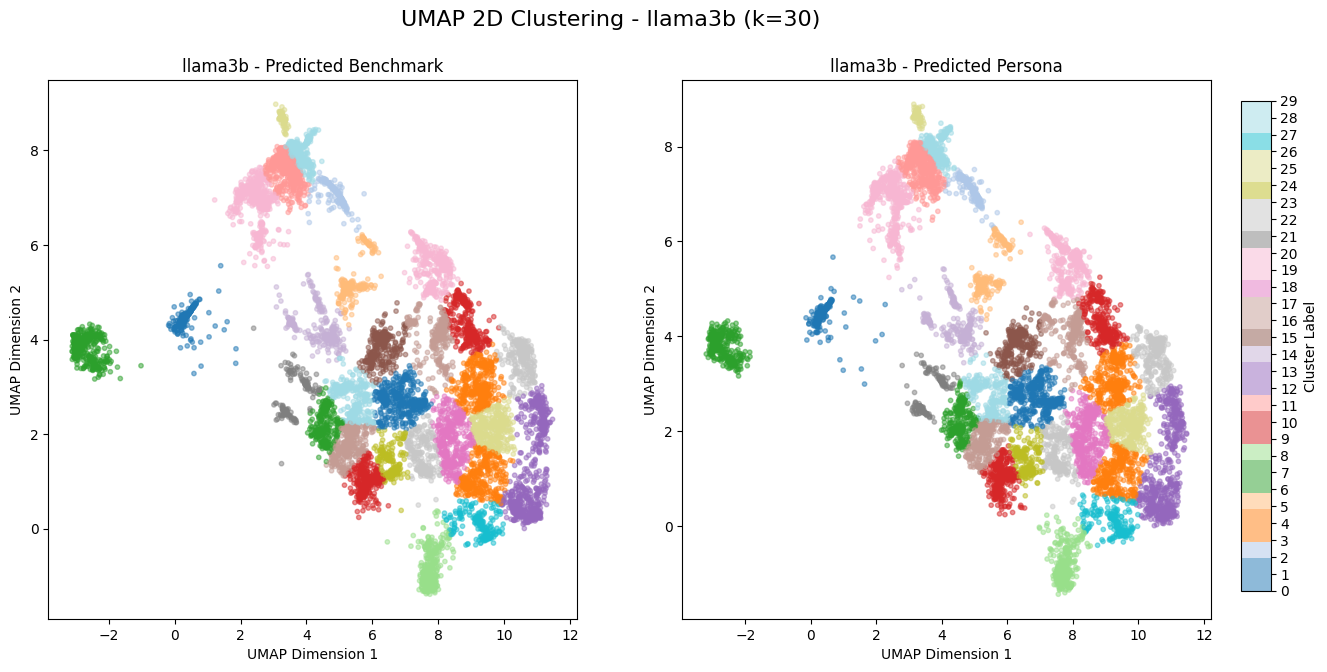

----------------------------------------
Processing model: llama70b


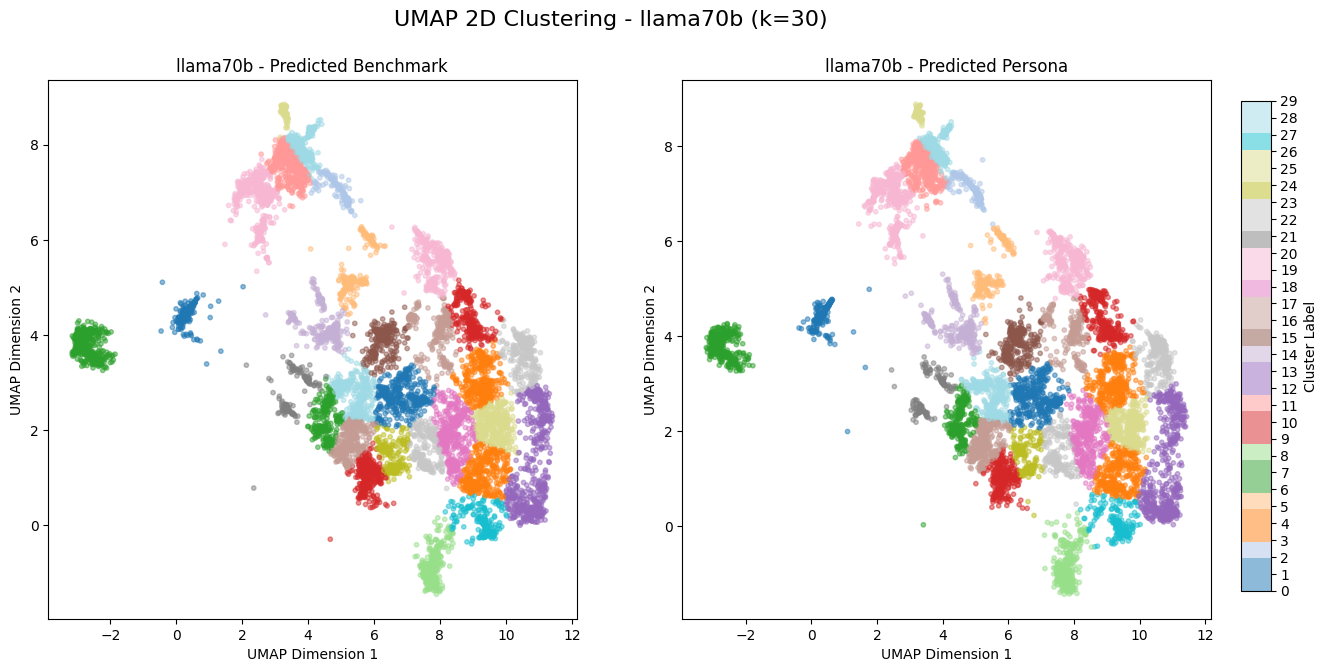

----------------------------------------
Processing model: mistral


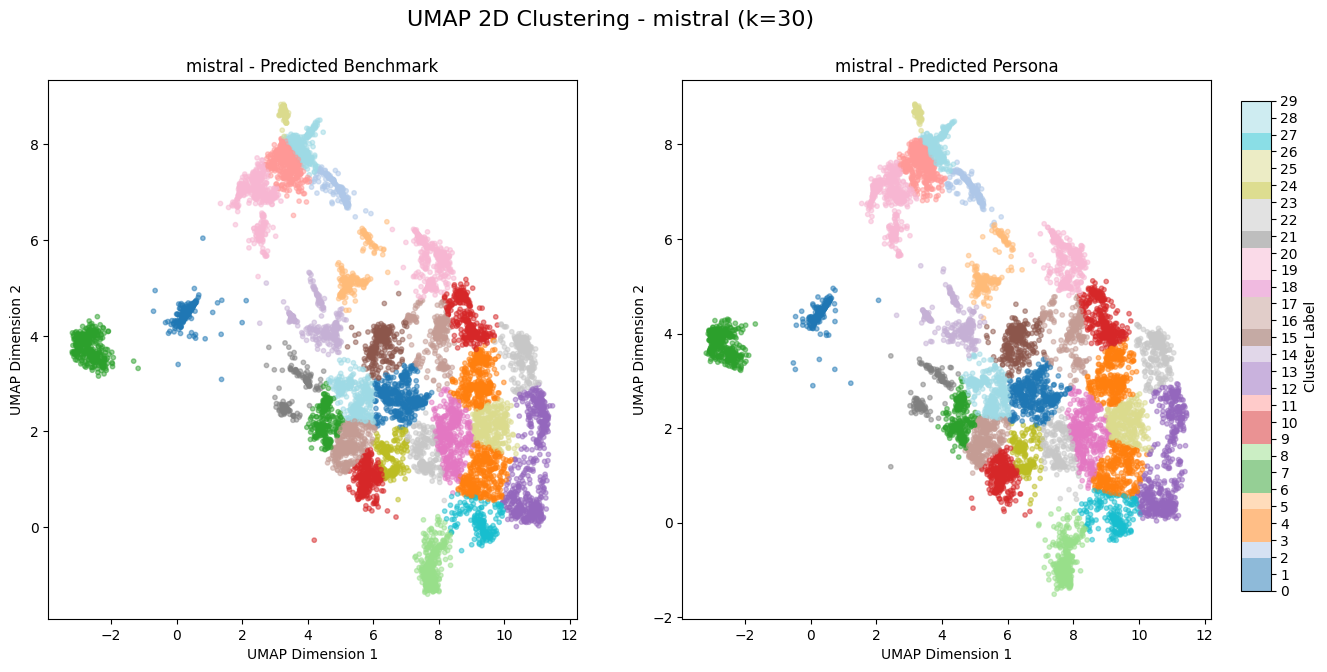

----------------------------------------


In [29]:
models = ['deepseek-r1', 'llama3b', 'llama70b', 'mistral']
k_clusters = 30

# 1. Fit UMAP & KMeans only once using reference embeddings
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.05,
                    metric='cosine', random_state=42)
reducer.fit(ref_embs_norm)

ref_embs_reduced_plot = reducer.transform(ref_embs_norm)

kmeans_ref_plot = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans_ref_plot.fit(ref_embs_reduced_plot)
ref_cluster_labels_plot = kmeans_ref_plot.labels_

# 2. Map job codes to reference clusters
code_to_ref_cluster = {code: ref_cluster_labels_plot[i] for i, code in enumerate(ref_embeddings_df.index)}

# 3. Plot reference once
colors = plt.get_cmap('tab20', k_clusters)
plt.figure(figsize=(8, 6))
plt.scatter(ref_embs_reduced_plot[:, 0], ref_embs_reduced_plot[:, 1],
            c=ref_cluster_labels_plot, cmap=colors, s=10, alpha=0.7)
plt.title(f'Reference Embeddings (UMAP 2D, k={k_clusters})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
cbar = plt.colorbar(ticks=np.arange(k_clusters))
cbar.set_label('Cluster Label')
plt.show()

# 4. Loop through each model and plot its benchmark/persona embeddings
for model in models:
    print(f"Processing model: {model}")
    
    # Extract embeddings
    all_bench_embs_norm = np.stack(
        df_all_embeddings[(df_all_embeddings['prompt'] == 'benchmark') & (df_all_embeddings['model'] == model)]['embedding'].values)
    all_pers_embs_norm = np.stack(
        df_all_embeddings[(df_all_embeddings['prompt'] == 'persona') & (df_all_embeddings['model'] == model)]['embedding'].values)

    # Reduce dimensions
    all_bench_embs_reduced_plot = reducer.transform(all_bench_embs_norm)
    all_pers_embs_reduced_plot = reducer.transform(all_pers_embs_norm)

    # Get true labels
    job_codes_bench = df_all_embeddings[(df_all_embeddings['prompt'] == 'benchmark') & (df_all_embeddings['model'] == model)]['code'].values
    true_labels_bench_plot = np.array([code_to_ref_cluster[code] for code in job_codes_bench])
    
    job_codes_pers = df_all_embeddings[(df_all_embeddings['prompt'] == 'persona') & (df_all_embeddings['model'] == model)]['code'].values
    true_labels_pers_plot = np.array([code_to_ref_cluster[code] for code in job_codes_pers])

    # Predict clusters using KMeans
    predicted_labels_bench_plot = kmeans_ref_plot.predict(all_bench_embs_reduced_plot)
    predicted_labels_pers_plot = kmeans_ref_plot.predict(all_pers_embs_reduced_plot)

    # Plot benchmark and persona side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    scatter_bench = axes[0].scatter(all_bench_embs_reduced_plot[:, 0], all_bench_embs_reduced_plot[:, 1],
                                    c=predicted_labels_bench_plot, cmap=colors, s=10, alpha=0.5)
    axes[0].set_title(f'{model} - Predicted Benchmark')
    axes[0].set_xlabel('UMAP Dimension 1')
    axes[0].set_ylabel('UMAP Dimension 2')

    scatter_pers = axes[1].scatter(all_pers_embs_reduced_plot[:, 0], all_pers_embs_reduced_plot[:, 1],
                                   c=predicted_labels_pers_plot, cmap=colors, s=10, alpha=0.5)
    axes[1].set_title(f'{model} - Predicted Persona')
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter_bench, cax=cbar_ax, ticks=np.arange(k_clusters))
    cbar.set_label('Cluster Label')

    plt.suptitle(f'UMAP 2D Clustering - {model} (k={k_clusters})', fontsize=16)
    plt.show()

    print("-" * 40)

In [30]:
# --- Configuration ---
n_clusters_kmeans = 30 # Your chosen k for KMeans
num_random_states = 10 # Number of random states to loop through
umap_n_components = 10 # UMAP output dimension
umap_n_neighbors = 15
umap_min_dist = 0.05
umap_metric = 'cosine' # Important for normalized embeddings

models = ['deepseek-r1', 'llama3b', 'llama70b', 'mistral']
# --- Store results for plotting ---
all_results = []

# --- Main Loop ---
for model_name in models:
    print(f"\n--- Processing Model: {model_name} ---")

    # Filter ref embeddings for the current model
    ref_embeddings_df_model = df_all_embeddings[
        (df_all_embeddings['prompt'] == 'ref') &
        (df_all_embeddings['model'] == model_name)
    ].drop_duplicates(subset=['code'])
    ref_embs_norm = np.stack(ref_embeddings_df_model['embedding'].values)

    # Check if there's enough data for ref embeddings for this model
    if len(ref_embs_norm) == 0:
        print(f"  No 'ref' embeddings found for {model_name}. Skipping this model.")
        continue
    
    # Filter benchmark and persona embeddings for the current model
    all_bench_embs_norm = np.stack(df_all_embeddings[
        (df_all_embeddings['prompt'] == 'benchmark') &
        (df_all_embeddings['model'] == model_name)
    ]['embedding'].values)

    all_pers_embs_norm = np.stack(df_all_embeddings[
        (df_all_embeddings['prompt'] == 'persona') &
        (df_all_embeddings['model'] == model_name)
    ]['embedding'].values)

    # Make sure we have embeddings for benchmark and persona to process
    if len(all_bench_embs_norm) == 0 or len(all_pers_embs_norm) == 0:
        print(f"  Not enough 'benchmark' or 'persona' embeddings for {model_name}. Skipping this model.")
        continue


    for i in range(num_random_states):
        current_random_state = i # Using 0 to 9 as random states

        print(f"  -> Running with random_state={current_random_state}")

        # --- 1. UMAP Reduction (fit on ref, transform all) ---
        # UMAP needs to be initialized with the *current random_state* for reproducibility
        reducer = umap.UMAP(n_components=umap_n_components,
                            n_neighbors=umap_n_neighbors,
                            min_dist=umap_min_dist,
                            metric=umap_metric,
                            random_state=current_random_state) # UMAP's random_state

        # Fit UMAP on the 'ref' embeddings specific to this model
        ref_embs_reduced = reducer.fit_transform(ref_embs_norm)

        # Transform all other embeddings using the *fitted* reducer
        all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
        all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

        # --- 2. K-Means Clustering on Reference Data ---
        # KMeans needs to be initialized with the *current random_state*
        kmeans_ref = KMeans(n_clusters=n_clusters_kmeans,
                            random_state=current_random_state, # KMeans' random_state
                            n_init='auto') # Using 'auto' as previously discussed

        # Fit K-Means on the *reduced* 'ref' embeddings
        kmeans_ref.fit(ref_embs_reduced)
        ref_cluster_labels = kmeans_ref.labels_

        # --- 3. Map Job Codes to Reference Clusters (for ground truth labels) ---
        # This maps the original job codes to the cluster labels derived from ref embeddings
        code_to_ref_cluster = {}
        for idx, code in enumerate(ref_embeddings_df_model['code'].values):
            code_to_ref_cluster[code] = ref_cluster_labels[idx]

        # --- 4. Create "Ground Truth" Labels for Generated Data ---
        # Get the 'code' values for the benchmark and persona embeddings
        job_codes_bench = df_all_embeddings[
            (df_all_embeddings['prompt'] == 'benchmark') &
            (df_all_embeddings['model'] == model_name)
        ]['code'].values
        
        job_codes_pers = df_all_embeddings[
            (df_all_embeddings['prompt'] == 'persona') &
            (df_all_embeddings['model'] == model_name)
        ]['code'].values

        # Map these codes to their corresponding ref cluster labels
        # Handle cases where a code might not exist in ref_embeddings_df_model (e.g., if ref_embeddings_df_model is smaller)
        # Assuming all codes in benchmark/persona should also be in ref for ground truth mapping.
        true_labels_bench = np.array([
            code_to_ref_cluster[code] for code in job_codes_bench if code in code_to_ref_cluster
        ])
        # If some codes in benchmark/persona are NOT in ref, you might need to adjust how
        # you filter 'all_bench_embs_reduced' / 'all_pers_embs_reduced' to match 'true_labels_bench'.
        # For simplicity, assuming a 1:1 match for now, implying all job codes are in ref.

        true_labels_pers = np.array([
            code_to_ref_cluster[code] for code in job_codes_pers if code in code_to_ref_cluster
        ])

        # IMPORTANT: Ensure the length of true_labels matches the predicted labels if filtering happened
        # If your 'code' lists for benchmark/persona are guaranteed to be a subset of the 'ref' codes,
        # then the lengths should naturally match. If not, you need to filter the embeddings arrays too.
        # For this example, assuming they match.

        # --- 5. Predict Clusters for Generated Data (using Reference KMeans Model) ---
        predicted_labels_bench = kmeans_ref.predict(all_bench_embs_reduced)
        predicted_labels_pers = kmeans_ref.predict(all_pers_embs_reduced)

        # --- 6. Calculate Adjusted Rand Index (ARI) ---
        # ARI requires arrays of the same length
        if len(true_labels_bench) != len(predicted_labels_bench):
             print(f"    Warning: Length mismatch for benchmark. True: {len(true_labels_bench)}, Predicted: {len(predicted_labels_bench)}. Skipping ARI.")
             ari_bench = np.nan
        else:
            ari_bench = adjusted_rand_score(true_labels_bench, predicted_labels_bench)
        
        if len(true_labels_pers) != len(predicted_labels_pers):
            print(f"    Warning: Length mismatch for persona. True: {len(true_labels_pers)}, Predicted: {len(predicted_labels_pers)}. Skipping ARI.")
            ari_pers = np.nan
        else:
            ari_pers = adjusted_rand_score(true_labels_pers, predicted_labels_pers)

        print(f"    ARI (Benchmark): {ari_bench:.4f}")
        print(f"    ARI (Persona): {ari_pers:.4f}")

        # Store results
        all_results.append({
            'model': model_name,
            'random_state': current_random_state,
            'ari_benchmark': ari_bench,
            'ari_persona': ari_pers
        })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)


--- Processing Model: deepseek-r1 ---
  -> Running with random_state=0


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6341
    ARI (Persona): 0.6500
  -> Running with random_state=1


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6465
    ARI (Persona): 0.6576
  -> Running with random_state=2


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6543
    ARI (Persona): 0.6626
  -> Running with random_state=3


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6437
    ARI (Persona): 0.6548
  -> Running with random_state=4


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6360
    ARI (Persona): 0.6508
  -> Running with random_state=5


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6543
    ARI (Persona): 0.6530
  -> Running with random_state=6


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6534
    ARI (Persona): 0.6596
  -> Running with random_state=7


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6541
    ARI (Persona): 0.6710
  -> Running with random_state=8


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6510
    ARI (Persona): 0.6628
  -> Running with random_state=9


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6458
    ARI (Persona): 0.6543

--- Processing Model: llama3b ---
  -> Running with random_state=0


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6640
    ARI (Persona): 0.6613
  -> Running with random_state=1


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6831
    ARI (Persona): 0.6763
  -> Running with random_state=2


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7034
    ARI (Persona): 0.6980
  -> Running with random_state=3


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6831
    ARI (Persona): 0.6710
  -> Running with random_state=4


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6815
    ARI (Persona): 0.6706
  -> Running with random_state=5


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6894
    ARI (Persona): 0.6787
  -> Running with random_state=6


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6910
    ARI (Persona): 0.6780
  -> Running with random_state=7


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7004
    ARI (Persona): 0.6946
  -> Running with random_state=8


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6985
    ARI (Persona): 0.6853
  -> Running with random_state=9


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6826
    ARI (Persona): 0.6705

--- Processing Model: llama70b ---
  -> Running with random_state=0


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7332
    ARI (Persona): 0.7185
  -> Running with random_state=1


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7264
    ARI (Persona): 0.7110
  -> Running with random_state=2


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7358
    ARI (Persona): 0.7180
  -> Running with random_state=3


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7403
    ARI (Persona): 0.7221
  -> Running with random_state=4


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7212
    ARI (Persona): 0.7090
  -> Running with random_state=5


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7210
    ARI (Persona): 0.7047
  -> Running with random_state=6


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6934
    ARI (Persona): 0.6854
  -> Running with random_state=7


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7275
    ARI (Persona): 0.7134
  -> Running with random_state=8


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7301
    ARI (Persona): 0.7063
  -> Running with random_state=9


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6986
    ARI (Persona): 0.6866

--- Processing Model: mistral ---
  -> Running with random_state=0


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6785
    ARI (Persona): 0.6695
  -> Running with random_state=1


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6753
    ARI (Persona): 0.6641
  -> Running with random_state=2


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6943
    ARI (Persona): 0.6793
  -> Running with random_state=3


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.7013
    ARI (Persona): 0.6855
  -> Running with random_state=4


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6894
    ARI (Persona): 0.6840
  -> Running with random_state=5


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6938
    ARI (Persona): 0.6780
  -> Running with random_state=6


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6866
    ARI (Persona): 0.6635
  -> Running with random_state=7


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6865
    ARI (Persona): 0.6785
  -> Running with random_state=8


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6856
    ARI (Persona): 0.6722
  -> Running with random_state=9


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    ARI (Benchmark): 0.6862
    ARI (Persona): 0.6670



--- Results for Barplot ---
         model  random_state prompt_type  ari_score
0  deepseek-r1             0   benchmark   0.634061
1  deepseek-r1             1   benchmark   0.646528
2  deepseek-r1             2   benchmark   0.654334
3  deepseek-r1             3   benchmark   0.643716
4  deepseek-r1             4   benchmark   0.636048
      model  random_state prompt_type  ari_score
75  mistral             5     persona   0.677971
76  mistral             6     persona   0.663493
77  mistral             7     persona   0.678514
78  mistral             8     persona   0.672204
79  mistral             9     persona   0.666994


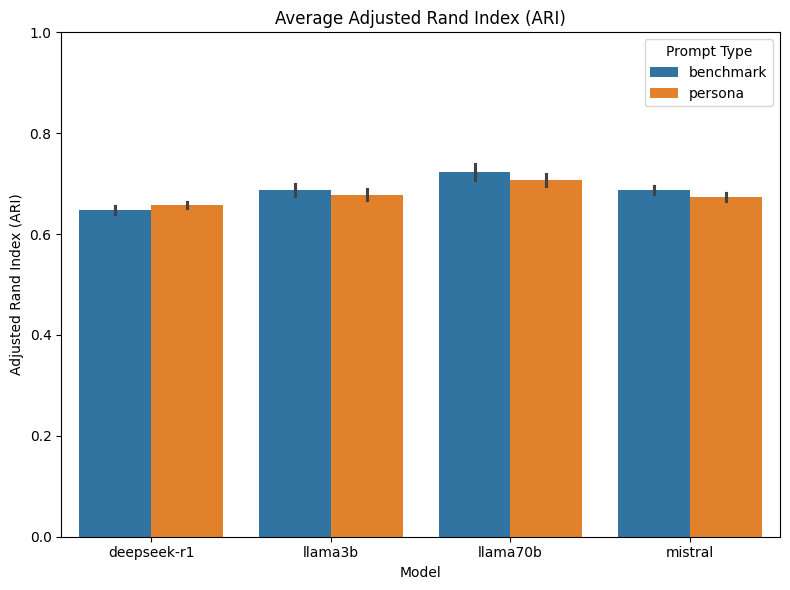

In [31]:
# --- 7. Prepare for Barplot ---
# Melt the DataFrame to have 'metric' and 'score' columns for easy plotting
plot_df = results_df.melt(id_vars=['model', 'random_state'],
                          value_vars=['ari_benchmark', 'ari_persona'],
                          var_name='prompt_type',
                          value_name='ari_score')

# Rename prompt_type for better labels
plot_df['prompt_type'] = plot_df['prompt_type'].replace({
    'ari_benchmark': 'benchmark',
    'ari_persona': 'persona'
})

print("\n--- Results for Barplot ---")
print(plot_df.head())
print(plot_df.tail())

# --- 8. Create Barplot ---
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='model', y='ari_score', hue='prompt_type', errorbar='sd')
plt.title('Average Adjusted Rand Index (ARI)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.xlabel('Model')
plt.ylim(0, 1) # ARI is between -1 and 1, but often 0 to 1 for non-random clustering
plt.legend(title='Prompt Type')
plt.tight_layout()
plt.show()

# # Optional: Box plot to show distribution over random states
# plt.figure(figsize=(14, 7))
# sns.boxplot(data=plot_df, x='model', y='ari_score', hue='prompt_type')
# plt.title('Distribution of Average Adjusted Rand Index (ARI)')
# plt.ylabel('Adjusted Rand Index (ARI)')
# plt.xlabel('Model')
# plt.ylim(0, 1)
# plt.legend(title='Prompt Type')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [32]:
# --- STATISTICAL TEST: Paired Samples t-test ---
print("\n--- Paired Samples t-test for ARI Difference (Benchmark vs. Persona) ---")
print("H0: Mean(ARI_benchmark) - Mean(ARI_persona) = 0 (No significant difference)")
print("H1: Mean(ARI_benchmark) - Mean(ARI_persona) != 0 (Significant difference)")
print("Significance level (alpha) = 0.01")

stat_test_results = []

for model_name in models:
    # Filter ARI scores for the current model
    model_bench_ari = results_df[results_df['model'] == model_name]['ari_benchmark'].dropna()
    model_pers_ari = results_df[results_df['model'] == model_name]['ari_persona'].dropna()

    # Ensure we have enough data points and equal lengths for paired test
    if len(model_bench_ari) < 2 or len(model_pers_ari) < 2 or len(model_bench_ari) != len(model_pers_ari):
        print(f"\nModel: {model_name} - Not enough valid ARI pairs ({len(model_bench_ari)} vs {len(model_pers_ari)}) for t-test. Skipping.")
        stat_test_results.append({
            'model': model_name,
            'mean_ari_benchmark': model_bench_ari.mean(),
            'mean_ari_persona': model_pers_ari.mean(),
            'mean_diff': np.nan,
            't_statistic': np.nan,
            'p_value': np.nan,
            'significant_diff': 'N/A'
        })
        continue

    # Perform the paired t-test
    t_statistic, p_value = stats.ttest_rel(model_bench_ari, model_pers_ari)

    # Calculate mean difference
    mean_diff = model_bench_ari.mean() - model_pers_ari.mean()

    # Determine significance
    is_significant = "Yes" if p_value < 0.01 else "No"
    
    print(f"\nModel: {model_name}")
    print(f"  Mean ARI (Benchmark): {model_bench_ari.mean():.4f}")
    print(f"  Mean ARI (Persona):   {model_pers_ari.mean():.4f}")
    print(f"  Mean Difference (Bench - Pers): {mean_diff:.4f}")
    print(f"  T-statistic: {t_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant Difference (alpha=0.01)? {is_significant}")

    stat_test_results.append({
        'model': model_name,
        'mean_ari_benchmark': model_bench_ari.mean(),
        'mean_ari_persona': model_pers_ari.mean(),
        'mean_diff': mean_diff,
        't_statistic': t_statistic,
        'p_value': p_value,
        'significant_diff': is_significant
    })

stat_results_df = pd.DataFrame(stat_test_results)
print("\n--- Summary of Statistical Test Results ---")
print(stat_results_df)


--- Paired Samples t-test for ARI Difference (Benchmark vs. Persona) ---
H0: Mean(ARI_benchmark) - Mean(ARI_persona) = 0 (No significant difference)
H1: Mean(ARI_benchmark) - Mean(ARI_persona) != 0 (Significant difference)
Significance level (alpha) = 0.01

Model: deepseek-r1
  Mean ARI (Benchmark): 0.6473
  Mean ARI (Persona):   0.6576
  Mean Difference (Bench - Pers): -0.0103
  T-statistic: -6.0897
  P-value: 0.0002
  Significant Difference (alpha=0.01)? Yes

Model: llama3b
  Mean ARI (Benchmark): 0.6877
  Mean ARI (Persona):   0.6784
  Mean Difference (Bench - Pers): 0.0093
  T-statistic: 7.7887
  P-value: 0.0000
  Significant Difference (alpha=0.01)? Yes

Model: llama70b
  Mean ARI (Benchmark): 0.7227
  Mean ARI (Persona):   0.7075
  Mean Difference (Bench - Pers): 0.0153
  T-statistic: 11.3587
  P-value: 0.0000
  Significant Difference (alpha=0.01)? Yes

Model: mistral
  Mean ARI (Benchmark): 0.6878
  Mean ARI (Persona):   0.6742
  Mean Difference (Bench - Pers): 0.0136
  T-stati

In [33]:
stat_results_df

,model,mean_ari_benchmark,mean_ari_persona,mean_diff,t_statistic,p_value,significant_diff
0,deepseek-r1,0.647331,0.657645,-0.010314,-6.089677,0.000182,Yes
1,llama3b,0.687685,0.678424,0.009261,7.788710,0.000027,Yes
2,llama70b,0.722741,0.707488,0.015253,11.358730,0.000001,Yes
3,mistral,0.687759,0.674152,0.013608,8.018811,0.000022,Yes


In [34]:
results_df
# get the mean, median and std of the ARI scores for each model and prompt type
ari_summary = results_df.groupby(['model']).agg({
    'ari_benchmark': ['mean', 'median', 'std'],
    'ari_persona': ['mean', 'median', 'std']
}).reset_index()
ari_summary

model ari_benchmark                     ari_persona            \
                        mean    median       std        mean    median   
0  deepseek-r1      0.647331  0.648745  0.007558    0.657645  0.656192   
1      llama3b      0.687685  0.686230  0.011581    0.678424  0.677131   
2     llama70b      0.722741  0.726971  0.015381    0.707488  0.709996   
3      mistral      0.687759  0.686589  0.007563    0.674152  0.675088   

             
        std  
0  0.006505  
1  0.011384  
2  0.012615  
3  0.008007

In [35]:
x = corr_df.groupby(['model', 'comparison']).agg({'spearman_rho':['mean','median', 'std']}).reset_index()[['model', 'comparison', 'spearman_rho']]#.pivot(index='model', columns='comparison', values='spearman_rho').reset_index()
x

model comparison spearman_rho                    
                                  mean    median       std
0  deepseek-r1  benchmark     0.581315  0.580043  0.012874
1  deepseek-r1    persona     0.591461  0.593190  0.011901
2      llama3b  benchmark     0.644268  0.645065  0.008793
3      llama3b    persona     0.655155  0.653873  0.011250
4     llama70b  benchmark     0.687421  0.691104  0.009047
5     llama70b    persona     0.684038  0.683559  0.008070
6      mistral  benchmark     0.685672  0.682932  0.010835
7      mistral    persona     0.678998  0.679071  0.008517

In [36]:
latex_body = stat_results_df.to_latex(
    index=False,
    float_format='%.3f',
    column_format='lcccccc',
    caption='Descriptive Statistics of Related Recall',
    label='tab:des_recall',
    escape=False
)

# Wrap tabular part with \resizebox
latex_with_resizebox = latex_body.replace(
    r'\begin{tabular}',
    r'''\resizebox{\textwidth}{!}{%
    \begin{tabular}'''
).replace(
    r'\end{tabular}',
    r'''\end{tabular}%
    }''' 
)

print(latex_with_resizebox)


\begin{table}
\caption{Descriptive Statistics of Related Recall}
\label{tab:des_recall}
\resizebox{\textwidth}{!}{%
    \begin{tabular}{lcccccc}
\toprule
model & mean_ari_benchmark & mean_ari_persona & mean_diff & t_statistic & p_value & significant_diff \\
\midrule
deepseek-r1 & 0.647 & 0.658 & -0.010 & -6.090 & 0.000 & Yes \\
llama3b & 0.688 & 0.678 & 0.009 & 7.789 & 0.000 & Yes \\
llama70b & 0.723 & 0.707 & 0.015 & 11.359 & 0.000 & Yes \\
mistral & 0.688 & 0.674 & 0.014 & 8.019 & 0.000 & Yes \\
\bottomrule
\end{tabular}%
    }
\end{table}

